# **Malaria Detection**

## **Problem Definition**
Malaria is a lethal disease caused by parasites that enter the bloodstream and damage red blood cells (RBCs). Early detection and treatment are crucial to prevent complications, death, and the spread of the disease within the community. Traditional medical examinations for malaria detection are time-consuming and require trained professionals, whose accuracy depends heavily on their training and experience.

Developing an automated system to detect malaria from images of a patient’s RBCs is therefore highly valuable. Such a system needs to efficiently process image data and produce highly accurate predictions. Given the potentially fatal nature of malaria, a high recall rate is essential to ensure that all or most cases are detected.

Since malaria is caused by a parasite that damages RBCs, the system must distinguish between parasitized and uninfected RBCs in the images. To achieve this, we devise a supervised learning algorithm utilizing a convolutional neural network (CNN) trained on a large labelled dataset of RBC images, including both parasitized and uninfected cells. CNNs are a popular neural network architecture particularly effective for image analysis.

## **Data Description**

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>

**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


## **Programming Environment Setup**

### **Loading libraries**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import collections
from tqdm import tqdm

from google.colab.patches import cv2_imshow

### **Loading Data From Google Drive**


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
CAPSTONE_PATH = '/content/drive/MyDrive/Colab Notebooks/MIT ADS/Capstone/Malaria Detection/Capstone'
TRAINING_DATAPATH = os.path.join(CAPSTONE_PATH, 'cell_images/train')
TESTING_DATAPATH = os.path.join(CAPSTONE_PATH, 'cell_images/test')
CATEGORIES = ['parasitized', 'uninfected']
IMG_SIZE = 64

In [6]:
def load_data(data_path):
  X, y = [], []
  for label, category in zip([1, 0], CATEGORIES):
    path = os.path.join(data_path, category)
    cell_type = category
    print(path)
    for img in tqdm(os.listdir(path)):
      img_path = os.path.join(path, img)
      img_array = cv2.imread(img_path)
      new_image = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      X.append(np.array(new_image))
      y.append(label)

  return X, y

The extracted folder has separate folders for train and test data. Each folder contains images of parasitized and uninfected cells, and each image may be of different sizes.

The size of all images are first converted to be the same and are stacked to form a 4D arrays. This is necessary for the data to be used by the convolutional neural network. For this purpose, I convert the image data to be of size 64 x 64. The number of channles and the number of images remain the same.

In [ ]:
X_train, y_train = load_data(TRAINING_DATAPATH)

In [ ]:
X_test, y_test = load_data(TESTING_DATAPATH)

In [ ]:
X_train_np = np.stack(X_train)
X_test_np = np.stack(X_test)
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

The processed images numpy arrays and labels are saved to Google Drive for fast loading later on.

In [ ]:
np.save(os.path.join(CAPSTONE_PATH, 'X_train.npy'), X_train_np)
np.save(os.path.join(CAPSTONE_PATH, 'X_test.npy'), X_test_np)
np.save(os.path.join(CAPSTONE_PATH, 'y_train.npy'), y_train_np)
np.save(os.path.join(CAPSTONE_PATH, 'y_test.npy'), y_test_np)

In [9]:
X_train_np = np.load(os.path.join(CAPSTONE_PATH, 'X_train.npy'))
X_test_np = np.load(os.path.join(CAPSTONE_PATH, 'X_test.npy'))
y_train_np = np.load(os.path.join(CAPSTONE_PATH, 'y_train.npy'))
y_test_np = np.load(os.path.join(CAPSTONE_PATH, 'y_test.npy'))

## **Data Exploration, Visualization and Preprocessing**

Here we check the size and bounds of the data we received and processed. In particular we want to understand the size of the training and testing set, as well as the format of the data and attribute about their distribution.

### **Check the shape of train and test images**

In [9]:
print(f"The shape of the train data is {X_train_np.shape}, and the shape of the test data is {X_test_np.shape}")

The shape of the train data is (24981, 64, 64, 3), and the shape of the test data is (2600, 64, 64, 3)


### **Check the shape of train and test labels**

In [10]:
print(f"The size of the train labels is {y_train_np.shape}, and the size of the test labels is {y_test_np.shape}")

The size of the train labels is (24981,), and the size of the test labels is (2600,)


**Observations and insights:**
The train and test labels are vectors of the same length as the number of samples in the train and test sample. The train/test split is roughly 90%/10%. The fact that they are vectors means that they will need to be one-hot encoded later to be used in the CNN models.


### **Check the minimum and maximum range of pixel values for train and test images**

In [11]:
X_train_np.dtype, np.min(X_train_np), np.max(X_train_np), np.min(X_test_np), np.max(X_test_np)

(dtype('uint8'), 0, 255, 0, 255)

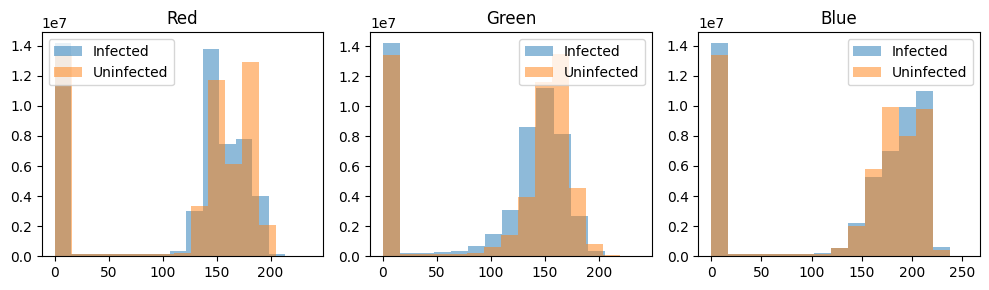

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
# plot the histogram of each channel
axes[0].hist(X_train_np[y_train_np==1, :, :, 0].ravel(), bins=15, alpha=0.5, label='Infected')
axes[0].hist(X_train_np[y_train_np==0, :, :, 0].ravel(), bins=15, alpha=0.5, label='Uninfected')
axes[0].legend()
axes[0].set_title('Red')
axes[1].hist(X_train_np[y_train_np==1, :, :, 1].ravel(), bins=15, alpha=0.5, label='Infected')
axes[1].hist(X_train_np[y_train_np==0, :, :, 1].ravel(), bins=15, alpha=0.5, label='Uninfected')
axes[1].legend()
axes[1].set_title('Green')
axes[2].hist(X_train_np[y_train_np==1, :, :, 2].ravel(), bins=15, alpha=0.5, label='Infected')
axes[2].hist(X_train_np[y_train_np==0, :, :, 2].ravel(), bins=15, alpha=0.5, label='Uninfected')
axes[2].legend()
axes[2].set_title('Blue')
plt.tight_layout()
plt.show()

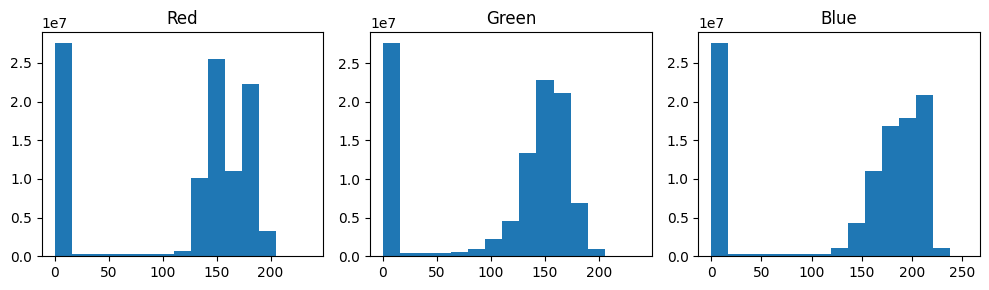

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
# plot the histogram of each channel
axes[0].hist(X_train_np[:, :, :, 0].ravel(), bins=15)
axes[0].set_title('Red')
axes[1].hist(X_train_np[:, :, :, 1].ravel(), bins=15)
axes[1].set_title('Green')
axes[2].hist(X_train_np[:, :, :, 2].ravel(), bins=15)
axes[2].set_title('Blue')
plt.tight_layout()
plt.show()

**Observations and insights:**
The min/max of the pixel values in both training and testing samples are 0 and 255 and are of type uint8. The images are likely represented as RGB imagnes with three channels with value between 0 and 255, able to represent 16 million colors.

we see that while Green and blue channels have only one mode. The Red channels have two modes. This may suggests that the Red channels contain information that can help differentiate between the parasitized and uninfected cells.



### **Count the number of values in both uninfected and parasitized**

In [ ]:
parasitized_idx = np.where(y_train_np == 1)[0]
uninfected_idx = np.where(y_train_np == 0)[0]

In [ ]:
train_label_count = collections.Counter(y_train_np)
test_label_count = collections.Counter(y_test_np)
train_label_count, test_label_count

(Counter({1: 12598, 0: 12383}), Counter({1: 1300, 0: 1300}))

###<b>Normalize the images

In [12]:
X_train_rgb_normalized = (X_train_np / 255.0).astype('float32')
X_test_rgb_normalized = (X_test_np / 255.0).astype('float32')

**Observations and insights:**
There are roughly equal number of parasitized and uninfected sample in both the training and testing samples. After I normalize the RGB channels to be between 0 and 1, I convert them into float32 datatype to reduce memory consumption and allow for faster computation. Also, the VGG16 model used at the end of the notebook also expect 32-bit precision.

###<b> Plot to check if the data is balanced

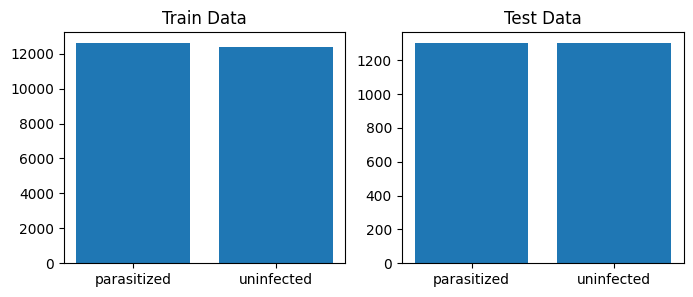

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
axes[0].bar(
  ['parasitized' if x == 1  else 'uninfected' for x in train_label_count.keys()],
  list(train_label_count.values())
)
axes[1].bar(
  ['parasitized' if x == 1  else 'uninfected' for x in test_label_count.keys()],
  list(test_label_count.values())
)
axes[0].set_title('Train Data')
axes[1].set_title('Test Data');

**Observations and insights:**
The number of parasitized and uninfected samples in both the training and testing data are roughly the same. Therefore there is no imbalance in data.

### **Visualize the images with subplot(6, 6) and figsize = (12, 12)**

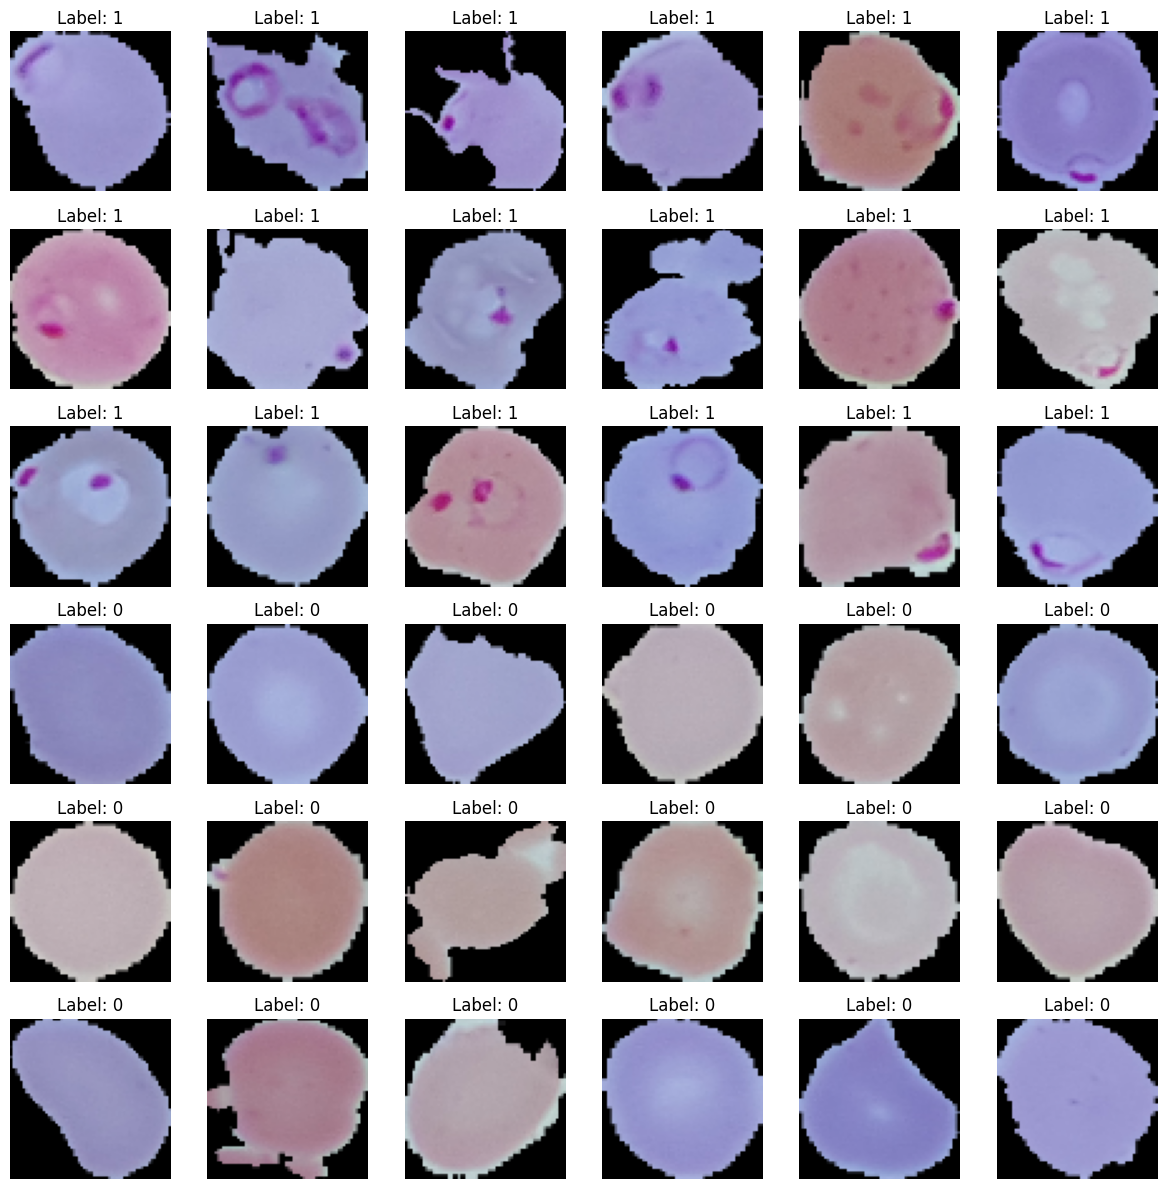

In [ ]:
fig = plt.figure(figsize=(12, 12))
for i in range(36):
  ax = fig.add_subplot(6, 6, i+1)
  sample_num = parasitized_idx[i] if i < 18 else uninfected_idx[i-18]
  ax.imshow(X_train_rgb_normalized[sample_num], cmap='gray')
  ax.title.set_text(f"Label: {y_train_np[sample_num]}")
  plt.axis('off')
plt.tight_layout()

**Observations and insights:**
The difference between the parasitized RBCs and the uninfected RBCs is the presence of purple spots or circles on the parasitized RBCs.

### **Plotting the mean images for parasitized and uninfected**

<b> Mean image for parasitized

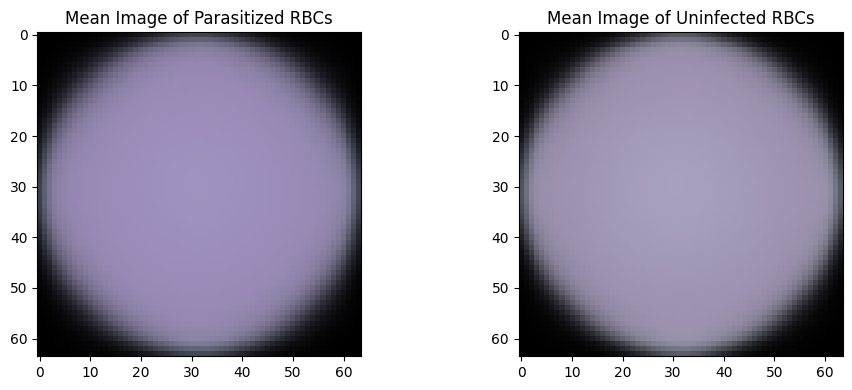

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(np.mean(X_train_rgb_normalized[parasitized_idx, :, :, :], axis=0))
axes[0].title.set_text('Mean Image of Parasitized RBCs');
axes[1].imshow(np.mean(X_train_rgb_normalized[uninfected_idx, :, :, :], axis=0));
axes[1].title.set_text('Mean Image of Uninfected RBCs');
plt.tight_layout()

**Observations and insights:**
The mean images of the parasitied and uninfected RBC look very similar, it would be difficult to discern the two types or RBC based on their mean images. If anything, the mean image of the parasitized RBCs has a slightly darker purple hue than the uninfected RBC mean image.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [13]:
X_train_hsv = []
for image in X_train_rgb_normalized:
  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype('float32')
  X_train_hsv.append(hsv_image)

###<b> Converting the test data

In [ ]:
X_test_hsv = []
for image in X_test_rgb_normalized:
  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype('float32')
  X_test_hsv.append(hsv_image)

Let's plot the value distribution of the HSV channels, as HSV channels have the following interpretation.

**Hue (H):** Represents the color type. It's measured in degrees, ranging from 0 to 360.

- 0°: Red
- 60°: Yellow
- 120°: Green
- 180°: Cyan
- 240°: Blue
- 300°: Magenta

**Saturation (S):** Represents the intensity or purity of the color. It's measured as a percentage, ranging from 0 to 100.

- 0%: Grayscale (no color)
- 100%: Fully saturated (pure color)

**Value (V):** Represents the brightness or lightness of the color. It's also measured as a percentage, ranging from 0 to 100.

- 0%: Black
- 100%: White

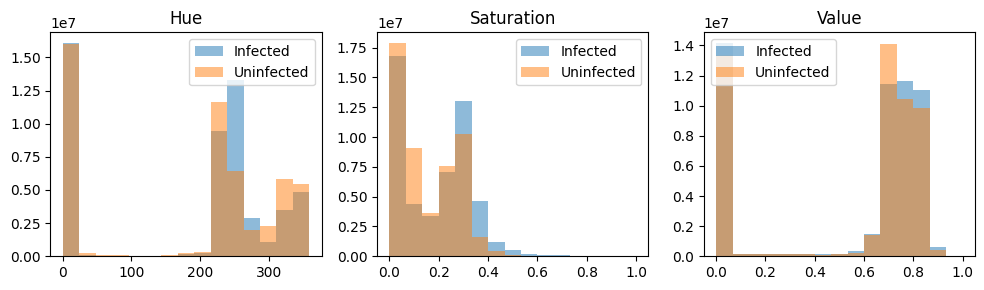

In [18]:
X_train_hsv_np = np.stack(X_train_hsv)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
# plot the histogram of each channel
axes[0].hist(X_train_hsv_np[y_train_np==1, :, :, 0].ravel(), bins=15, alpha=0.5, label='Infected')
axes[0].hist(X_train_hsv_np[y_train_np==0, :, :, 0].ravel(), bins=15, alpha=0.5, label='Uninfected')
axes[0].legend()
axes[0].set_title('Hue')
axes[1].hist(X_train_hsv_np[y_train_np==1, :, :, 1].ravel(), bins=15, alpha=0.5, label='Infected')
axes[1].hist(X_train_hsv_np[y_train_np==0, :, :, 1].ravel(), bins=15, alpha=0.5, label='Uninfected')
axes[1].legend()
axes[1].set_title('Saturation')
axes[2].hist(X_train_hsv_np[y_train_np==1, :, :, 2].ravel(), bins=15, alpha=0.5, label='Infected')
axes[2].hist(X_train_hsv_np[y_train_np==0, :, :, 2].ravel(), bins=15, alpha=0.5, label='Uninfected')
axes[2].legend()
axes[2].set_title('Value')
plt.tight_layout()
plt.show()

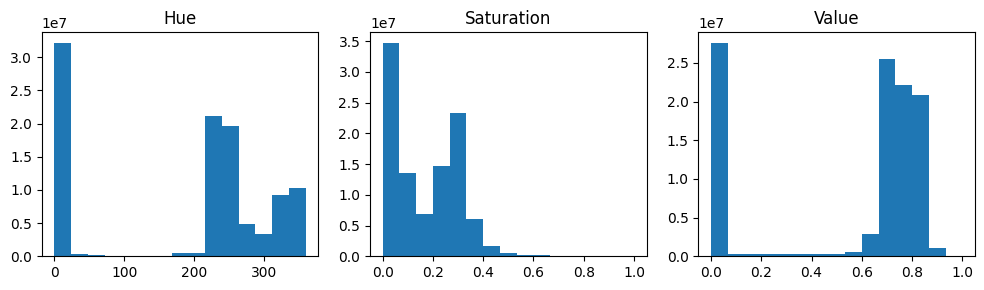

In [ ]:
X_train_hsv_np = np.stack(X_train_hsv)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
# plot the histogram of each channel
axes[0].hist(X_train_hsv_np[:, :, :, 0].ravel(), bins=15)
axes[0].set_title('Hue')
axes[1].hist(X_train_hsv_np[:, :, :, 1].ravel(), bins=15)
axes[1].set_title('Saturation')
axes[2].hist(X_train_hsv_np[:, :, :, 2].ravel(), bins=15)
axes[2].set_title('Value')
plt.tight_layout()
plt.show()

**Observations and insights:**
The Hue/Saturation/Value transformation can extract the dominant color. As seen in the sample images above, the main differentiator between the parasitized and uninfected RBC are the presence of purple shapes. The natural preprocessing of the image would be to bring out the dominant color to help the classification task.

The histogram of the Hue values in our training data suggests that there are two modes foe data above 200, corresponding to blue and magentta, respectively. The Magentta feature may be able to help the CNN to differentiate between parasitized and uninfected RBCs. Similarly, there are also two modes in the Saturation channel, the higher values probably correspond to the more colorful parts of the parasitized RBCs.

Finally, note that the value ranges for the 3 HSV channels are different from those of the RGB channels. Therefore when normalizeing the image later, each channels should be normalized separately by their own respective ranges

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
def gaussian_blur(images, kernel_size=(3, 3), sigma=0, border_type=cv2.BORDER_DEFAULT, hsv_ranges = np.array([360, 1, 1])
):
  blurred_images = []
  for image in images:
    blurred_images.append(
        cv2.GaussianBlur(image, kernel_size, sigma, border_type)
    )
  blurred_images_np = np.stack(blurred_images, axis=0)
  blurred_images_normalized = blurred_images_np / hsv_ranges
  return blurred_images_normalized

In [ ]:
X_train_blur_normalized = gaussian_blur(X_train_hsv)
X_train_blur_normalized.shape

(24981, 64, 64, 3)

In [ ]:
# sanity check
np.max(X_train_blur_normalized, axis=(0, 1, 2))

array([0.99723629, 0.99918813, 0.99142158])

###<b> Gaussian Blurring on test data

In [ ]:
X_test_blur_normalized = gaussian_blur(X_test_hsv)
X_test_blur_normalized.shape

(2600, 64, 64, 3)

In [ ]:
# sanity check
np.max(X_test_blur_normalized, axis=(0, 1, 2))

array([0.99513253, 0.97525501, 0.99509799])

**Observations and insights:**

The blurring of the image can potentailly help reduce noises in the images and nudge the algorithm to detect patterns instead of focusing on individual pixels. As the RBCs are photographs under a microscope, the images can exhibit noise caused by different lighting conditions or microscopic vibrations. By blurring out these types of noise, the algorithms are less likely to overfit to particular features presented in images produced under certain conditions.

Even though we have balanced labels within the training set, we do not know if these images are produced all under the same condition. It is possible that a facility where there is a higher percentage of parasitized RBCs are photographed uses a certain type of equipment. The image from that facility may contain certain features unrelated to malaria, and we do not want the CNN to capture those features. Blurring can potentially help with this.

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

We can also try equalizing the histogram of Green and Blue channels of the original images as the Red channel may be the only channel that contains features.

## **Model Building**

###<b> Importing the required libraries for building and training our Model

In [ ]:
import random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.metrics import FalseNegatives, BinaryAccuracy
from tensorflow.keras.losses import BinaryCrossentropy

def set_seed(seed = 47):
  backend.clear_session()
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

set_seed()

# common callbacks
def early_stopping_callback(monitor='val_loss', patience=2):
  early_stopping = EarlyStopping(
    monitor=monitor,
    patience=patience,
    min_delta=0.01,
    mode='max',
    restore_best_weights=True
  )
  return early_stopping

def checkpoint_callback(model_param_filepath, monitor='val_loss'):
  checkpoint = ModelCheckpoint(
      model_param_filepath,
      monitor=monitor,
      save_best_only=True,
      mode='max'
  )
  return checkpoint

def learning_rate_scheduler_callback(epoch_steps, lr_multiplier=0.5):
  def lr_scheduler(epoch, lr):
    if epoch % epoch_steps == 0 and epoch != 0:
      return lr * lr_multiplier
    else:
      return lr

  lr_scheduler_callback = LearningRateScheduler(lr_scheduler)
  return lr_scheduler_callback


####<B>One Hot Encoding the train and test labels

In [ ]:
y_train_one_hot = to_categorical(y_train_np)
y_test_one_hot = to_categorical(y_test_np)

### **Supporting Functions**

#### **Plotting Confusion Matrix**

In [ ]:
def plot_confusion_matrix(confusion_matrix, class_names=(1, 0), title='Confusion Matrix', cmap='Blues'):
    """
    Plots a confusion matrix using Matplotlib and Seaborn.

    Parameters:
    confusion_matrix (np.ndarray): The confusion matrix to be plotted.
    class_names (list): List of class names corresponding to the confusion matrix.
    title (str): Title of the plot.
    cmap (str): Colormap to be used for the plot.

    Returns:
    None
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap=cmap, xticklabels=class_names, yticklabels=class_names)

    plt.title(title, fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(rotation=0)
    plt.yticks(rotation=90)

    plt.tight_layout()
    plt.show()


#### **Plotting Training and Validation Metrics over Epochs**
This utility function allows us to see the training and validation set metrics as the models are trained over epochs.

In [ ]:
def plot_training_stats(history, metric='accuracy'):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3.5))
  acc_ax, loss_ax = axes
  # summarize history for accuracy
  acc_ax.plot(history.history[metric])
  acc_ax.plot(history.history['val_'+metric])
  acc_ax.title.set_text(f'model {metric}')
  acc_ax.yaxis.label.set_text(metric)
  acc_ax.xaxis.label.set_text('epoch')
  acc_ax.legend(['train', 'validation'], loc='upper left')
  # summarize history for loss
  loss_ax.plot(history.history['loss'])
  loss_ax.plot(history.history['val_loss'])
  loss_ax.title.set_text('model loss')
  loss_ax.yaxis.label.set_text('loss')
  loss_ax.xaxis.label.set_text('epoch')
  loss_ax.legend(['train', 'validation'], loc='upper left')
  plt.show()

#### **Visualize Layers**
We can see what the different Conv2D layers learn from the image. We can pass the image through each kernel and visualize their outputs.

In [ ]:
def visualize_activations(model, rgb_img_tensor, img_tensor, layer_names=None):
    # Create a model that will return the outputs of the chosen layers
    if layer_names is None:
        layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

    plt.imshow(np.squeeze(rgb_img_tensor))
    plt.show()

    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    # Get the activations
    activations = activation_model.predict(img_tensor)

    # Plot the activations of each filter in each layer
    for layer_name, activation in zip(layer_names, activations):
        num_filters = activation.shape[-1]
        size = activation.shape[1]

        # Tile the activation channels in a grid
        n_cols = num_filters // 16
        display_grid = np.zeros((size * n_cols, size * 16))

        for col in range(n_cols):
            for row in range(16):
                channel_image = activation[0, :, :, col * 16 + row]
                channel_image -= channel_image.mean()
                if channel_image.std() != 0:
                  channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

## **Base Model**


###<b> Building the model

In [ ]:
def build_base_model():
  set_seed()

  model = Sequential()
  model.add(Conv2D(16, (2, 2), padding = "same", activation = "relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, (2, 2), padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (2, 2), padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))

  return model

###<b> Compiling the model

In [ ]:
base_model = build_base_model()
base_model.compile(
  optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.005),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [ ]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

<b> Using Callbacks

In [ ]:
# use a checkpoint callback to save the best model
model_base_filepath = os.path.join(CAPSTONE_PATH, 'model_base.h5')
checkpoint_base = checkpoint_callback(model_base_filepath)

<b> Fit and train our Model

In [ ]:
history_base = base_model.fit(
  X_train_blur_normalized,
  y_train_one_hot,
  epochs=10,
  validation_split=0.1,
  shuffle=True,
  callbacks=[checkpoint_base]
)

Epoch 1/10
703/703 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.7076

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


703/703 [==============================] - 17s 22ms/step - loss: 0.5521 - accuracy: 0.7076 - val_loss: 0.1254 - val_accuracy: 0.9604
Epoch 2/10
703/703 [==============================] - 14s 20ms/step - loss: 0.1693 - accuracy: 0.9402 - val_loss: 0.1635 - val_accuracy: 0.9688
Epoch 3/10
703/703 [==============================] - 14s 20ms/step - loss: 0.1245 - accuracy: 0.9605 - val_loss: 0.1132 - val_accuracy: 0.9844
Epoch 4/10
703/703 [==============================] - 14s 19ms/step - loss: 0.0987 - accuracy: 0.9670 - val_loss: 0.0655 - val_accuracy: 0.9940
Epoch 5/10
703/703 [==============================] - 14s 19ms/step - loss: 0.0906 - accuracy: 0.9711 - val_loss: 0.0574 - val_accuracy: 0.9940
Epoch 6/10
703/703 [==============================] - 14s 19ms/step - loss: 0.0825 - accuracy: 0.9728 - val_loss: 0.0780 - val_accuracy: 0.9892
Epoch 7/10
703/703 [==============================] - 14s 20ms/step - loss: 0.0759 - accuracy: 0.9750 - val_loss: 0.0557 - val_accuracy: 0.9944
Epo

###<b> Evaluating the model on test data

In [ ]:
y_pred_base = base_model.predict(X_test_blur_normalized)
y_pred_base_classes = np.argmax(y_pred_base, axis=1)
print(classification_report(y_test_np, y_pred_base_classes))

82/82 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



<b> Plotting the confusion matrix

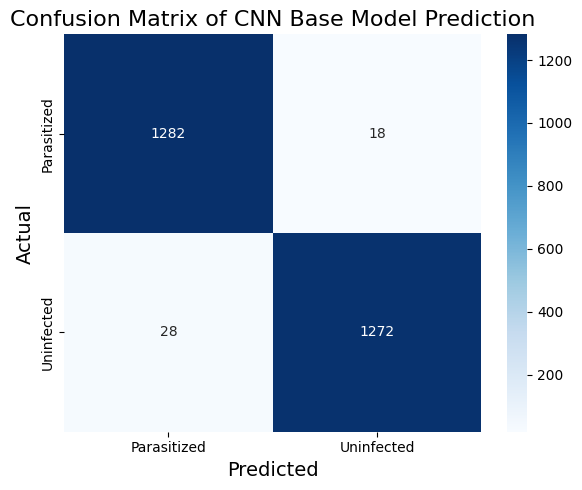

In [ ]:
plot_confusion_matrix(
    confusion_matrix(y_test_np, y_pred_base_classes, labels=[1, 0]),
    class_names=['Parasitized', 'Uninfected'],
    title='Confusion Matrix of CNN Base Model Prediction')

<b>Plotting the train and validation curves

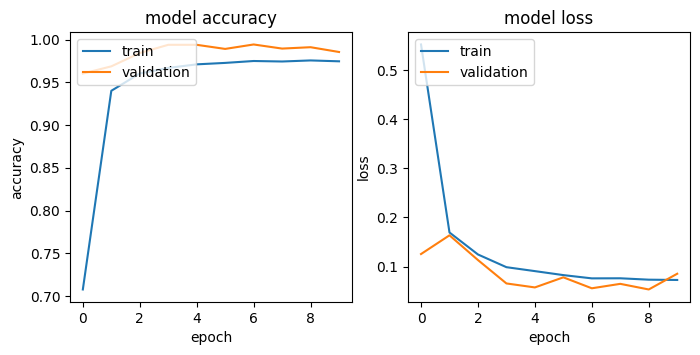

In [ ]:
plot_training_stats(history_base)

Let's see what the base model learn from an image it correctly classified as **parasitized**.

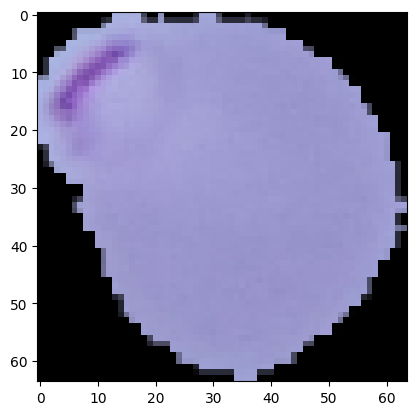

1/1 [==============================] - 0s 68ms/step


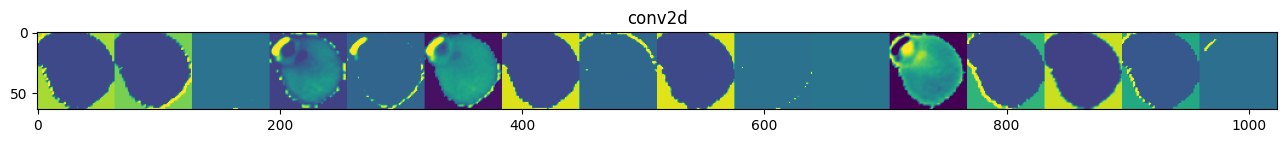

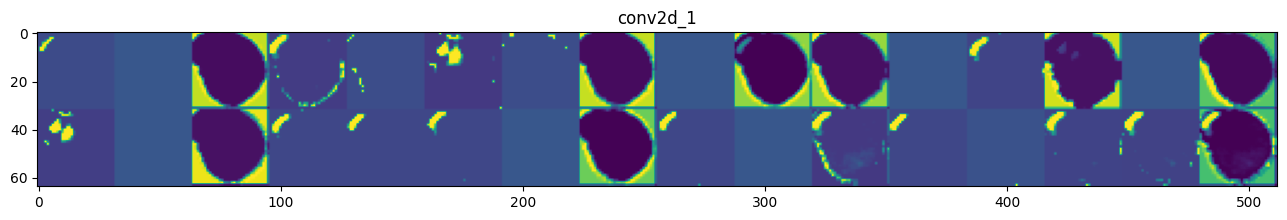

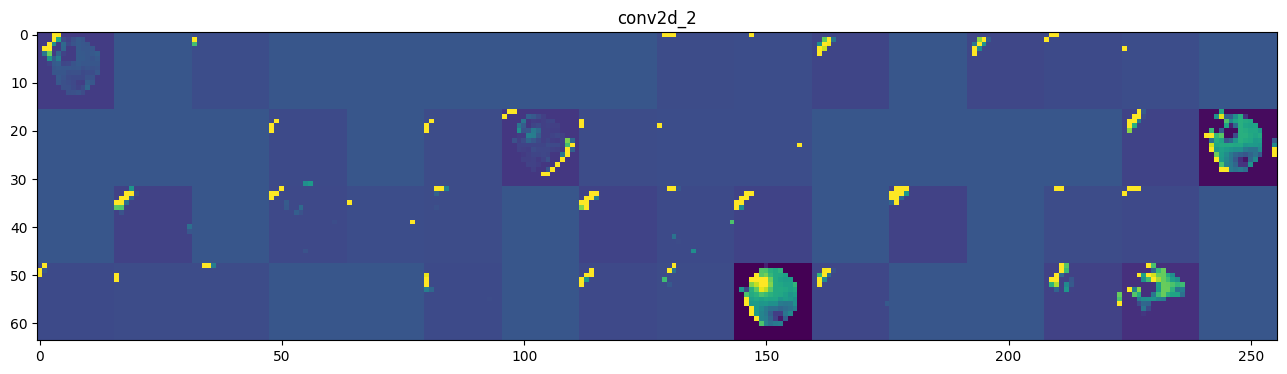

In [ ]:
img_idx = parasitized_idx[0:1]
visualize_activations(base_model, X_train_np[img_idx], X_train_blur_normalized[img_idx])

Let's see what the base model learn from an image it correctly classified as **uninfected**.

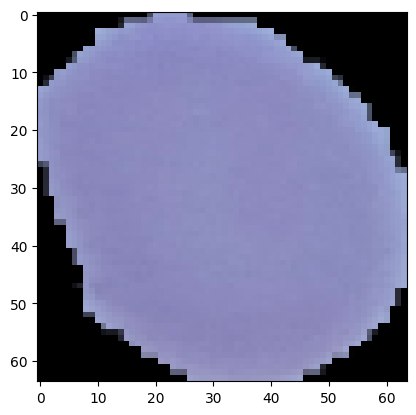

1/1 [==============================] - 0s 62ms/step


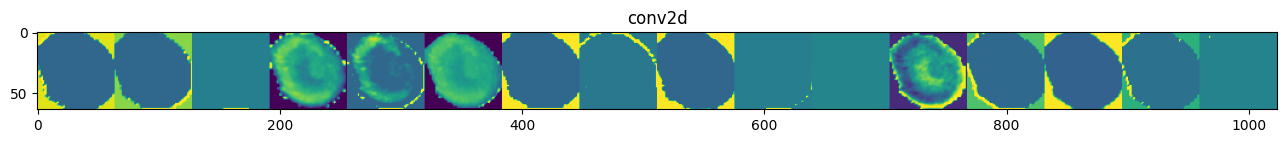

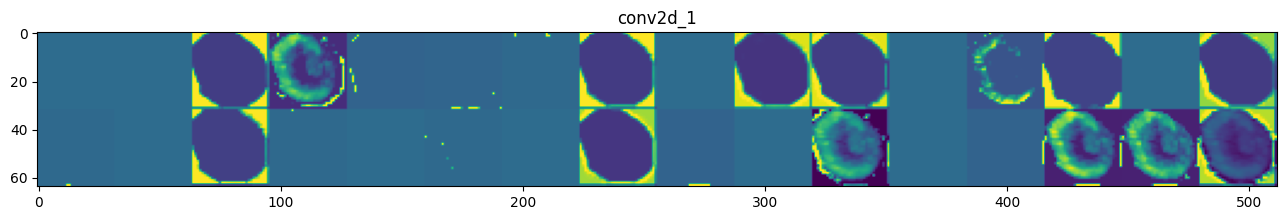

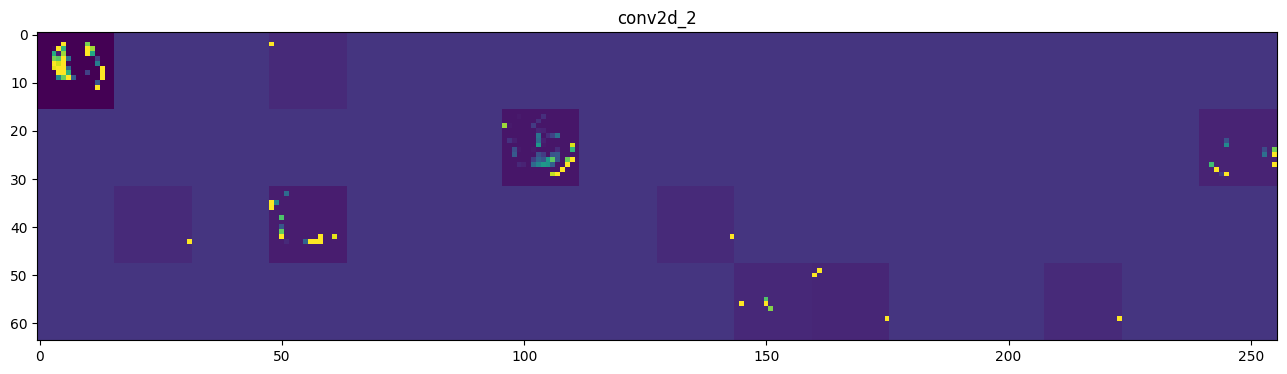

In [ ]:
img_idx = uninfected_idx[0:1]
visualize_activations(base_model, X_train_np[img_idx], X_train_blur_normalized[img_idx])

Lastly, let's visualize the Conv2D layers for a misclassified image.

[0.80849993 0.19150008] 1
[224]


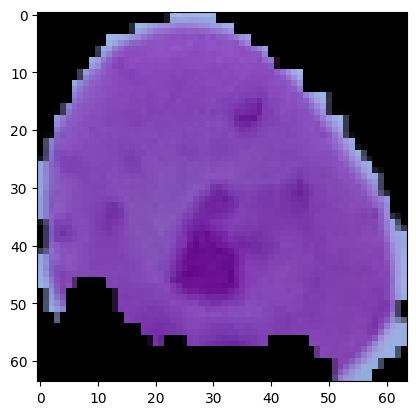

1/1 [==============================] - 0s 65ms/step


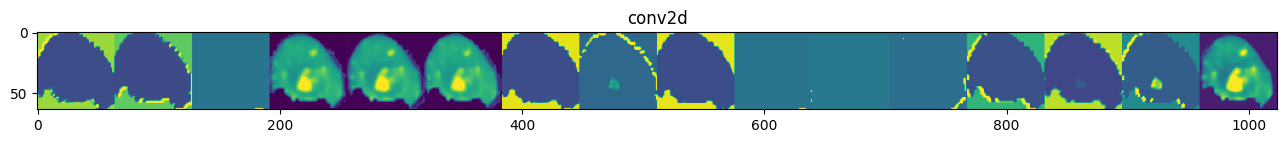

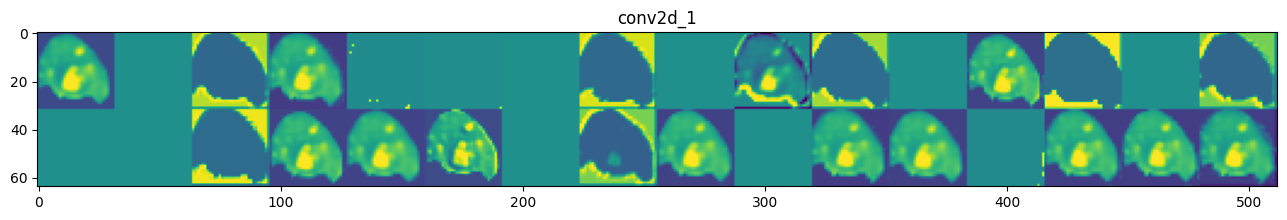

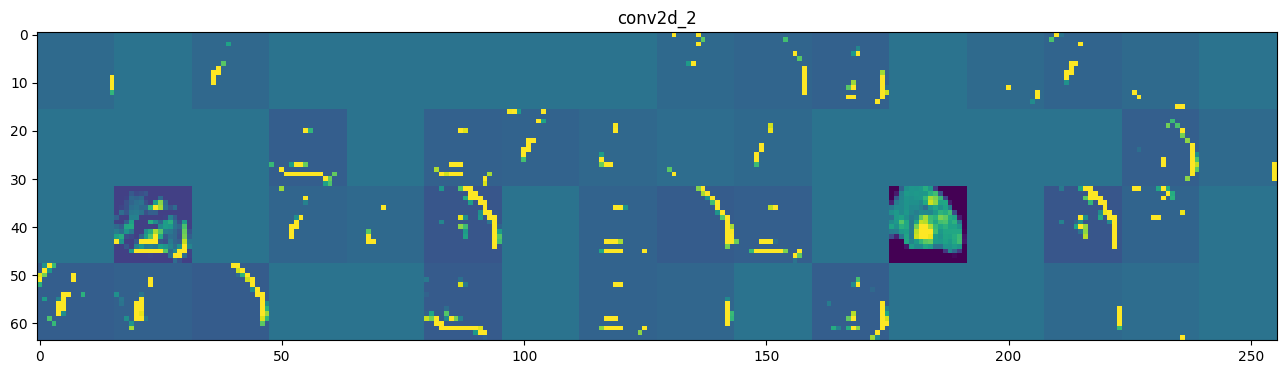

In [ ]:
mis_classified = np.where(y_pred_base_classes != y_test_np)[0][0]
print(y_pred_base[mis_classified], y_test_np[mis_classified])
img_idx = np.array([mis_classified])
print(img_idx)
visualize_activations(base_model, X_test_np[img_idx], X_test_blur_normalized[img_idx])

**Observations:**

In the base model, there are many activation layers that produce just constant images, but at the same time cannot capture parasitized cells that has more complex infection markings.

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

## **Model 1**
For Model 1, we first try to improve the performance of our model by adding new layers. Specifically, we added two more Conv2D layers and 1 more fully connected layer, while keeping the overall structure the same.


###<b> Building the Model

In [ ]:
def build_model_1():
  set_seed()

  model = Sequential()
  model.add(Conv2D(16, (2, 2), padding = "same", activation = "relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, (2, 2), padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (2, 2), padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (2, 2), padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(256, (2, 2), padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(256, activation='relu'))
  model.add(Dense(2, activation='softmax'))

  return model

In [ ]:
model_1 = build_model_1()

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [ ]:
model_1.compile(
  optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.005),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

<b> Using Callbacks

In [ ]:
# use a checkpoint callback to save the best model
model_1_filepath = os.path.join(CAPSTONE_PATH, 'model_1.h5')
checkpoint_1 = checkpoint_callback(model_1_filepath)

<b>Fit and Train the model

In [ ]:
history_1 = model_1.fit(
  X_train_blur_normalized,
  y_train_one_hot,
  batch_size=32,
  epochs=10,
  validation_split=0.1,
  shuffle=True,
  callbacks=[checkpoint_1]
)

Epoch 1/10
703/703 [==============================] - 17s 23ms/step - loss: 0.4997 - accuracy: 0.7239 - val_loss: 0.0564 - val_accuracy: 0.9944
Epoch 2/10
703/703 [==============================] - 16s 22ms/step - loss: 0.1111 - accuracy: 0.9638 - val_loss: 0.0566 - val_accuracy: 0.9864
Epoch 3/10
703/703 [==============================] - 15s 22ms/step - loss: 0.0915 - accuracy: 0.9703 - val_loss: 0.0500 - val_accuracy: 0.9848
Epoch 4/10
703/703 [==============================] - 15s 22ms/step - loss: 0.0770 - accuracy: 0.9747 - val_loss: 0.0490 - val_accuracy: 0.9756
Epoch 5/10
703/703 [==============================] - 15s 22ms/step - loss: 0.0751 - accuracy: 0.9752 - val_loss: 0.0416 - val_accuracy: 0.9860
Epoch 6/10
703/703 [==============================] - 15s 21ms/step - loss: 0.0729 - accuracy: 0.9771 - val_loss: 0.0429 - val_accuracy: 0.9852
Epoch 7/10
703/703 [==============================] - 15s 22ms/step - loss: 0.0693 - accuracy: 0.9772 - val_loss: 0.0394 - val_accuracy:

###<b> Evaluating the model

In [ ]:
# Make predictions on the test set using the second model.
y_pred_1 = model_1.predict(X_test_blur_normalized)
y_pred_1_classes = np.argmax(y_pred_1, axis=1)

# Print the obtained results using the classification report and the confusion matrix.
print(classification_report(y_test_np, y_pred_1_classes))

82/82 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



<b> Plotting the confusion matrix

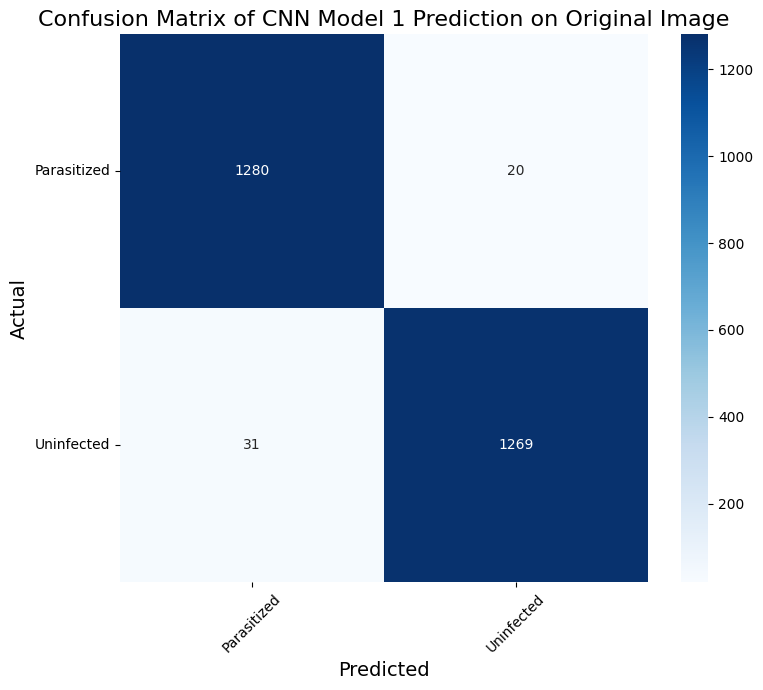

In [ ]:
plot_confusion_matrix(
    confusion_matrix(y_test_np, y_pred_1_classes, labels=[1, 0]),
    class_names=['Parasitized', 'Uninfected'],
    title='Confusion Matrix of CNN Model 1 Prediction on Original Image')

<b> Plotting the train and the validation curves

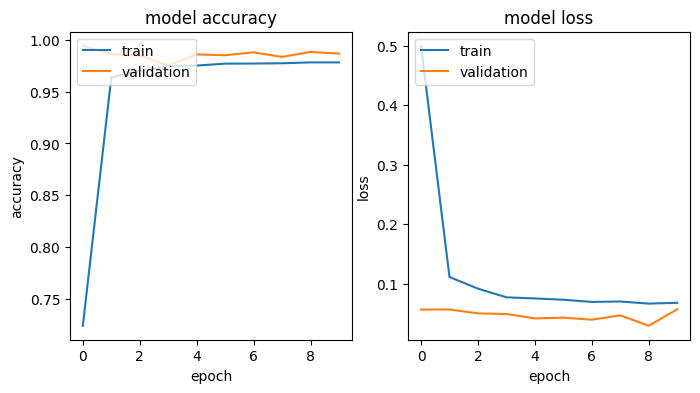

In [ ]:
plot_training_stats(history_1)

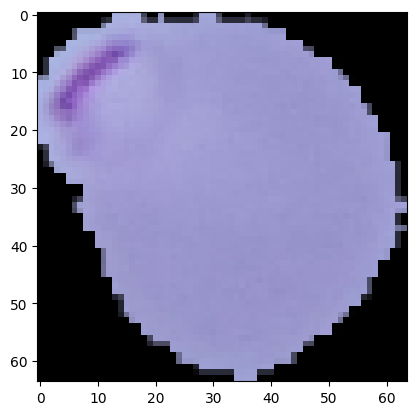

1/1 [==============================] - 0s 91ms/step


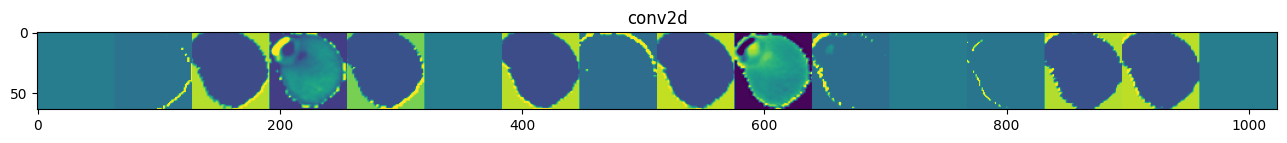

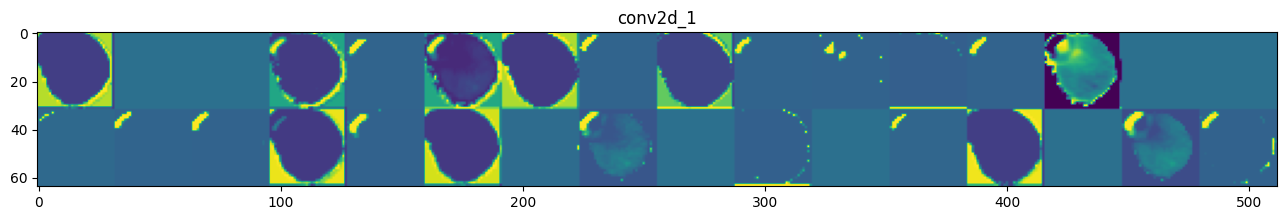

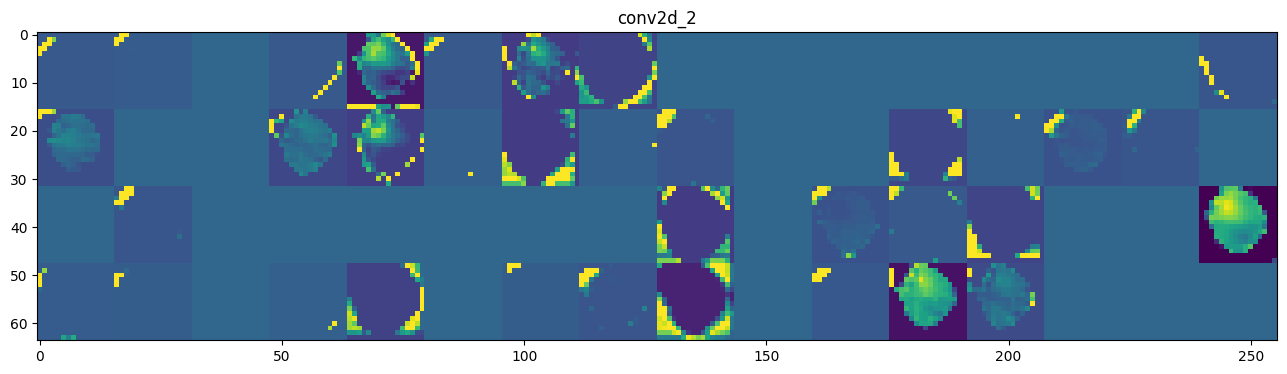

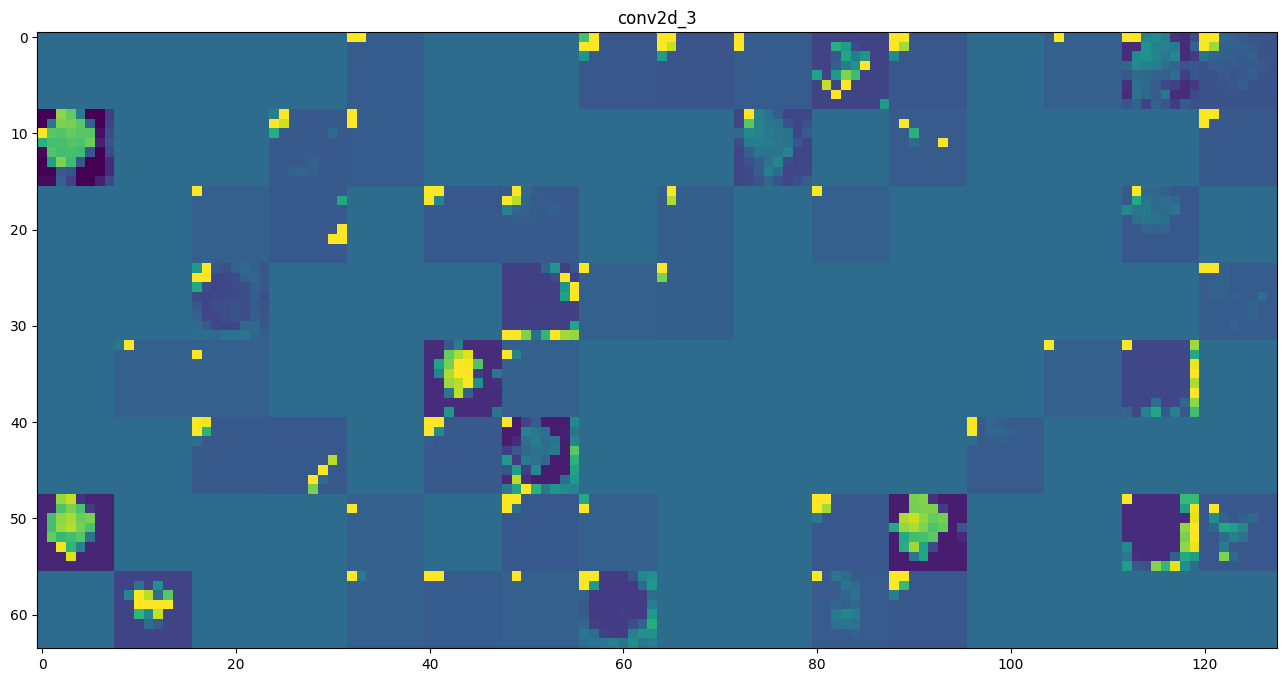

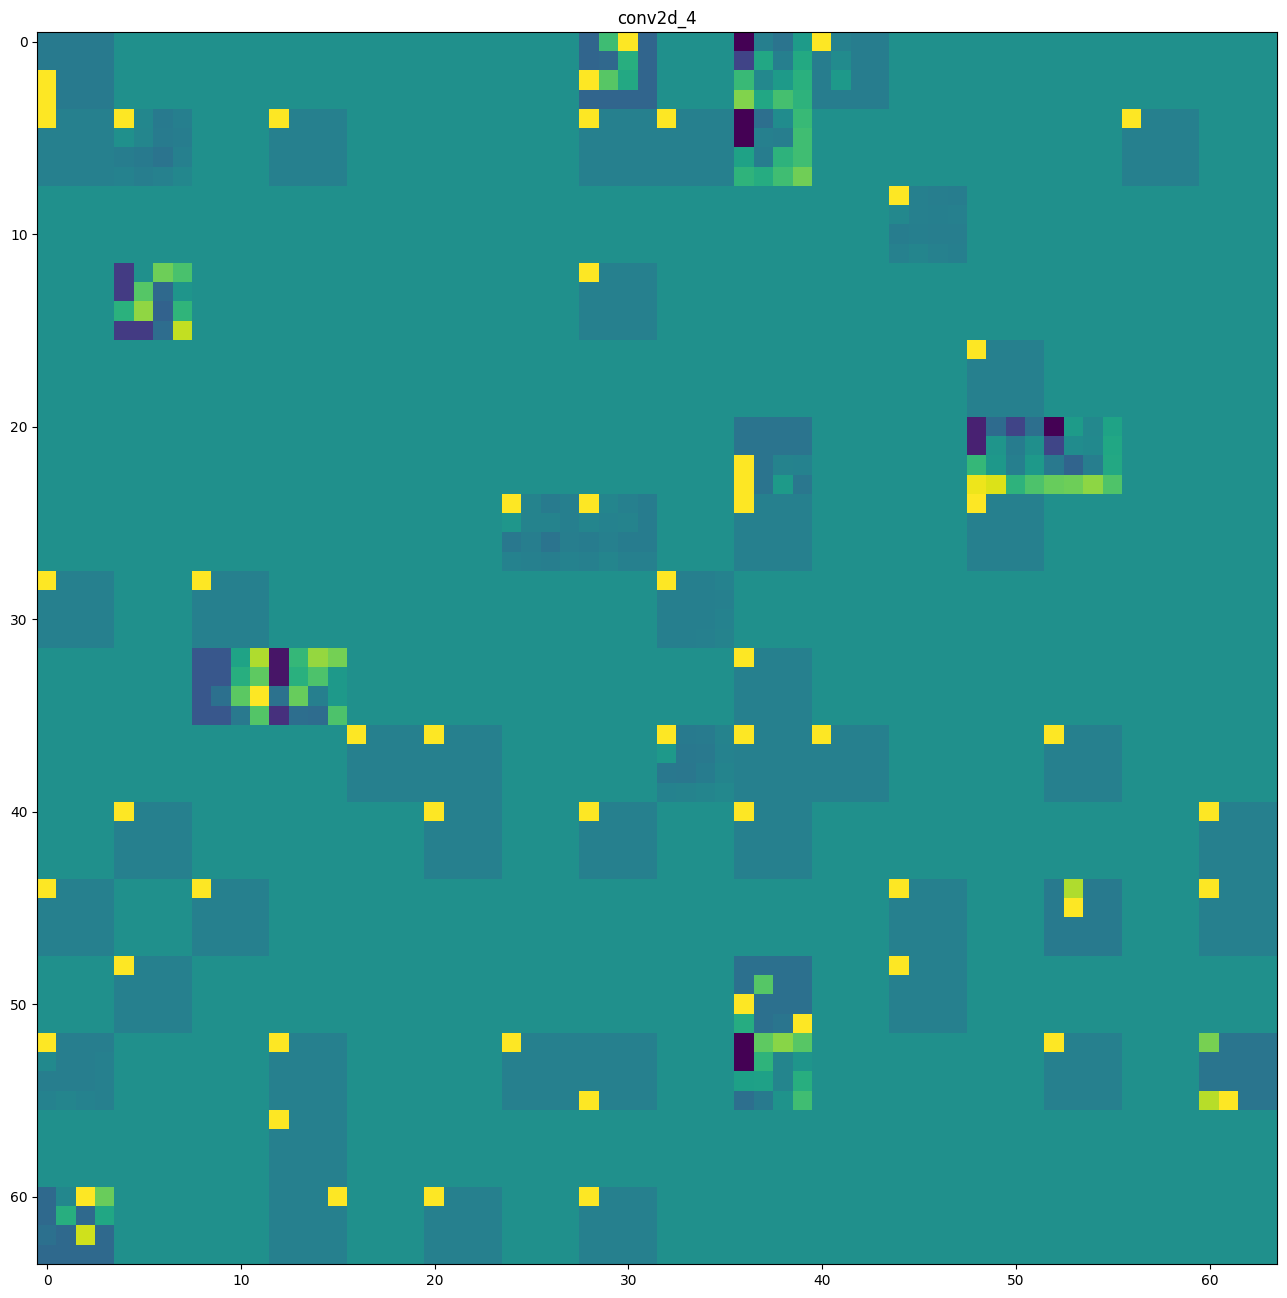

In [ ]:
img_idx = parasitized_idx[0:1]
visualize_activations(model_1, X_train_np[img_idx], X_train_blur_normalized[img_idx])

[0.77642226 0.22357778] 1
[404]


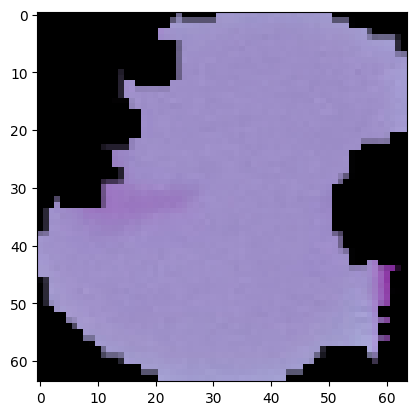

1/1 [==============================] - 0s 88ms/step


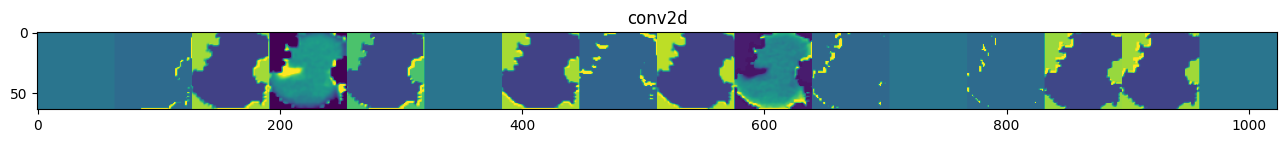

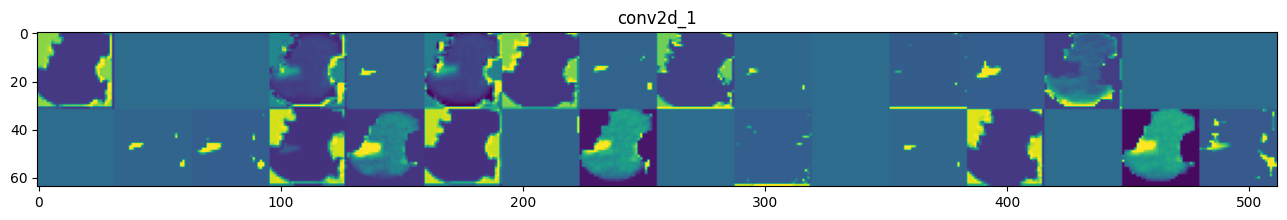

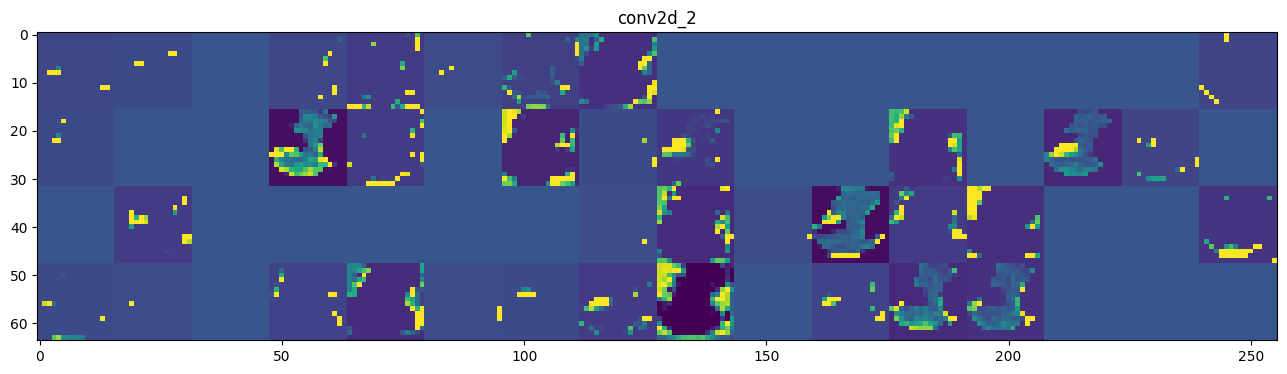

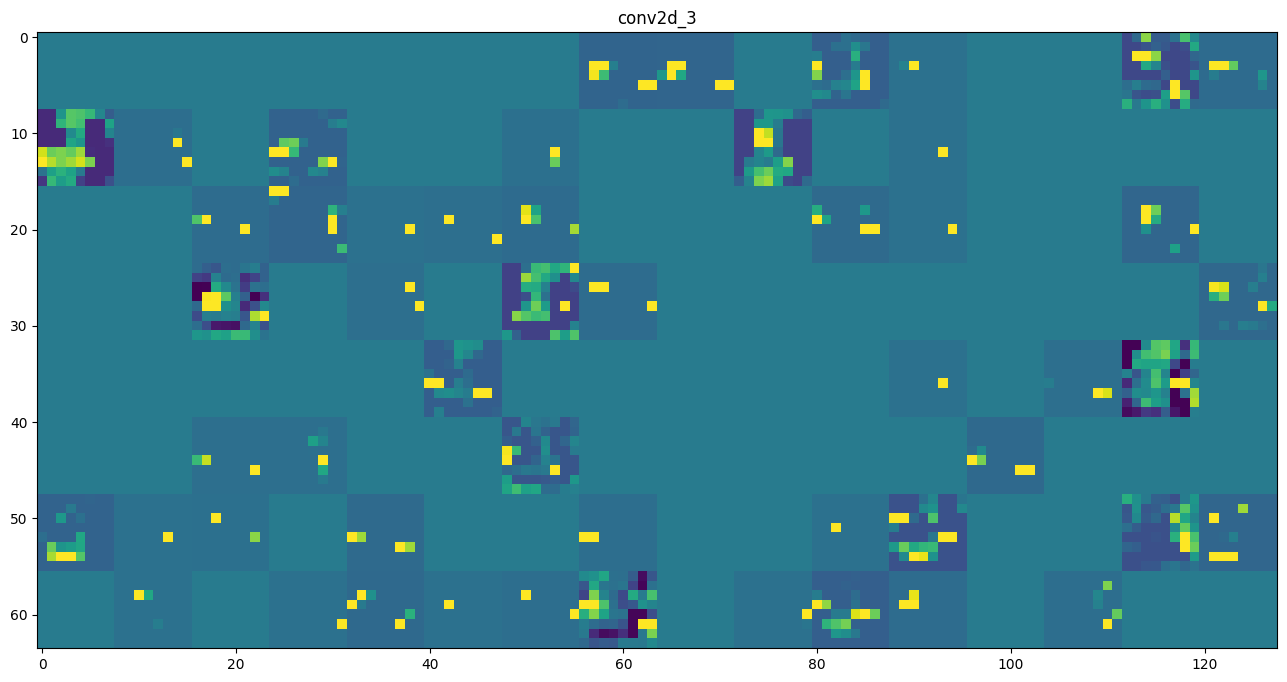

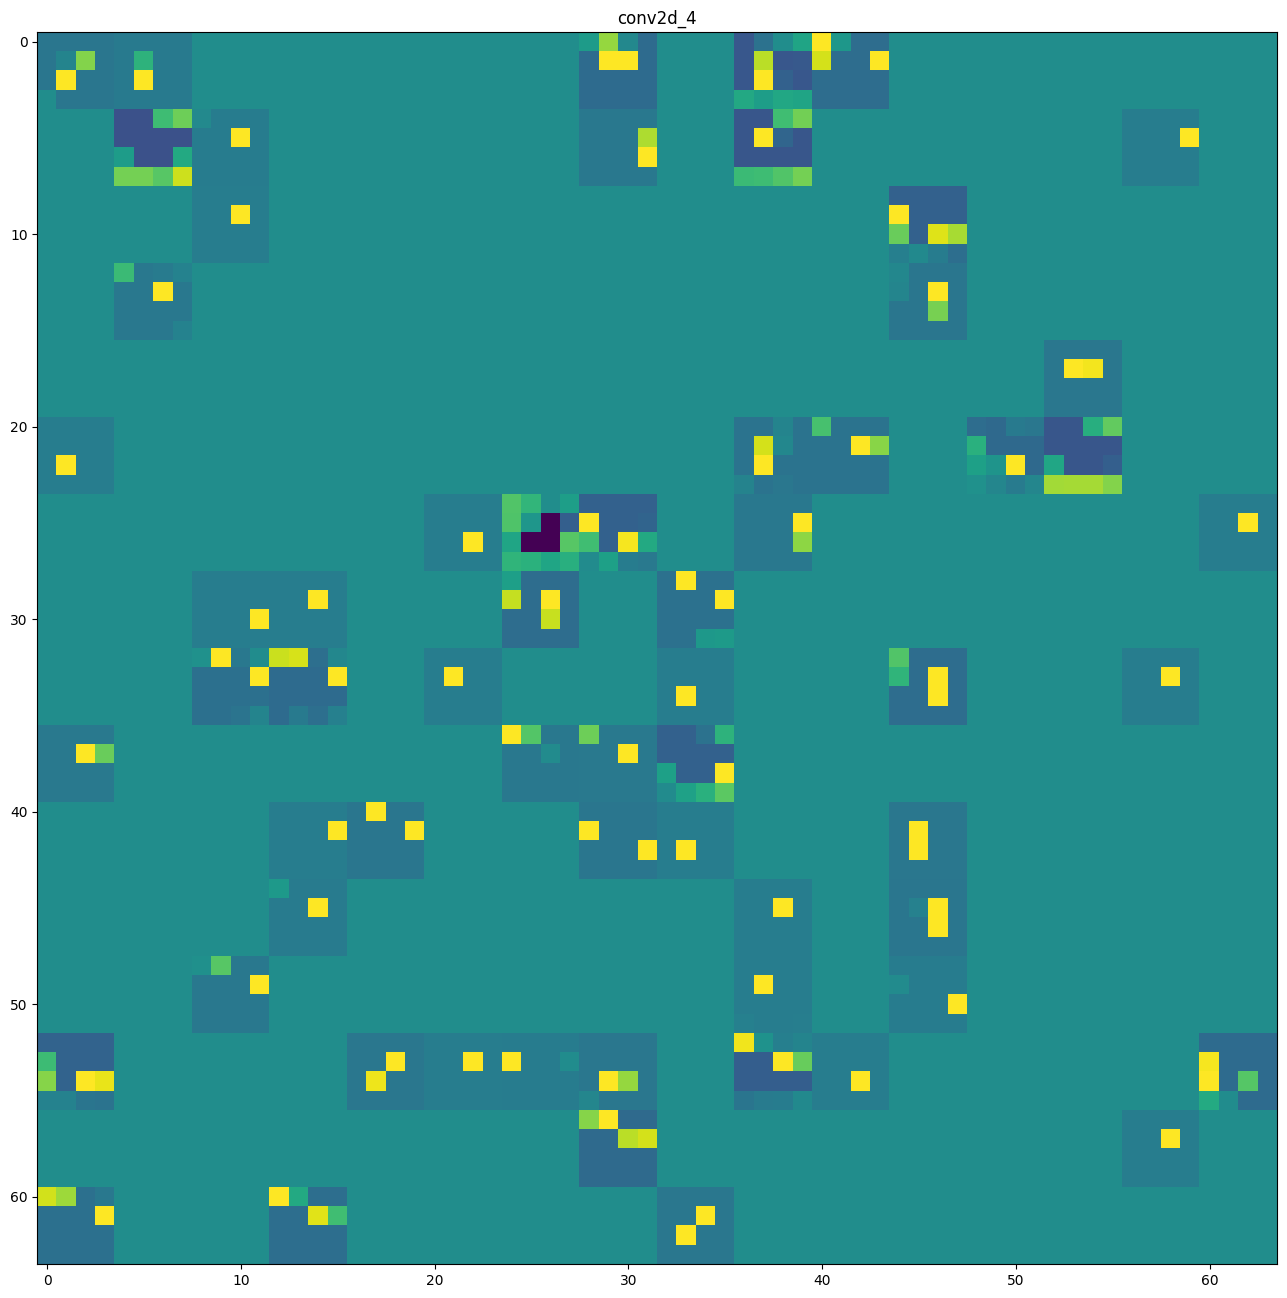

In [ ]:
mis_classified = np.where(y_pred_1_classes != y_test_np)[0][0]
print(y_pred_1[mis_classified], y_test_np[mis_classified])
img_idx = np.array([mis_classified])
print(img_idx)
visualize_activations(model_1, X_test_np[img_idx], X_test_blur_normalized[img_idx])

**Observation:**

Model 1 has 2 more Conv2D layer and 1 more fully connected layer. The performance is not better compared to the Base Model. For model 1, one of the misclassified image seems to have the purple shape at the boundary, which the model cannot capture well. The Conv2D layers often also just return a flat image. This may be caused by the diminishing gradient problem that may be solved with LeakyRelu activation and BatchNormalization.

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

## **Model 2**

**Model 2 with LeakyRelu and Batch Normalization**

The Batch Normalization can be used to stabilize the mean and variance of input to each layer so that back propagation is faster without diminishing or exploding gradient. LeakyRelu activation may also improve training by not allowing gradient to be at 0.

Some of the misclassified images have the purple shade near the boundary of the RBCs, which is difficult to be picked up by model 1. The LeakyRelu and Batch Normalization may help with these issues.

###<b> Building the Model

In [ ]:
def build_model_2():
  set_seed()

  model = Sequential()
  model.add(Conv2D(32, (2, 2), padding = "same", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2D(32, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2D(64, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(256, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dropout(0.5))
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(2, activation='softmax'))

  return model

In [ ]:
model_2 = build_model_2()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4128      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 32)        0

###<b>Compiling the model

In [ ]:
model_2.compile(
  optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.015),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

<b> Using callbacks

In [ ]:
# use a checkpoint callback to save the best model
model_2_filepath = os.path.join(CAPSTONE_PATH, 'model_2.h5')
checkpoint_2 = checkpoint_callback(model_2_filepath)

<b>Fit and train the model

In [ ]:
history_2 = model_2.fit(
  X_train_blur_normalized,
  y_train_one_hot,
  batch_size=128,
  epochs=10,
  validation_split=0.2,
  shuffle=True,
  callbacks=[checkpoint_2],
)

Epoch 1/10
157/157 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9374

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 66s 396ms/step - loss: 0.1792 - accuracy: 0.9374 - val_loss: 0.0108 - val_accuracy: 1.0000
Epoch 2/10
157/157 [==============================] - 58s 369ms/step - loss: 0.0993 - accuracy: 0.9660 - val_loss: 0.0080 - val_accuracy: 0.9996
Epoch 3/10
157/157 [==============================] - 58s 369ms/step - loss: 0.0852 - accuracy: 0.9701 - val_loss: 0.0170 - val_accuracy: 0.9966
Epoch 4/10
157/157 [==============================] - 59s 374ms/step - loss: 0.0760 - accuracy: 0.9750 - val_loss: 0.0210 - val_accuracy: 0.9974
Epoch 5/10
157/157 [==============================] - 58s 368ms/step - loss: 0.0718 - accuracy: 0.9752 - val_loss: 0.0433 - val_accuracy: 0.9880
Epoch 6/10
157/157 [==============================] - 56s 359ms/step - loss: 0.0729 - accuracy: 0.9753 - val_loss: 0.0257 - val_accuracy: 0.9928
Epoch 7/10
157/157 [==============================] - 56s 359ms/step - loss: 0.0672 - accuracy: 0.9769 - val_loss: 0.0183 - val_accuracy: 0.9

<b>Plotting the train and validation accuracy

In [ ]:
history_2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

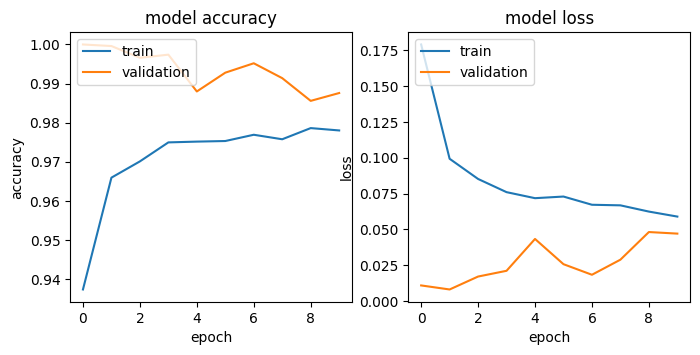

In [ ]:
plot_training_stats(history_2)

###<b>Evaluating the model

In [ ]:
y_pred_2 = model_2.predict(X_test_blur_normalized)
y_pred_2_classes = np.argmax(y_pred_2, axis=1)
print(classification_report(y_test_np, y_pred_2_classes))

82/82 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



<b> Generate the classification report and confusion matrix

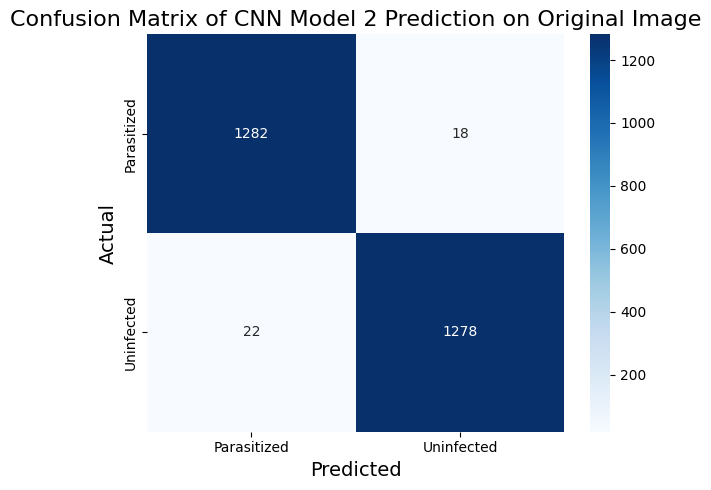

In [ ]:
plot_confusion_matrix(
    confusion_matrix(y_test_np, y_pred_2_classes, labels=(1, 0)),
    class_names=['Parasitized', 'Uninfected'],
    title='Confusion Matrix of CNN Model 2 Prediction on Original Image')

## **Model 2.5: Minimize False Negative more**

Here we test our own custom loss function that try to put more emphasis on false negatives.

In [ ]:
def custom_loss(y_true, y_pred):
    # Define the penalty weight for false negatives
    penalty_weight = 2.0  # Adjust this weight as needed

    # Convert y_true and y_pred to float32 for calculations
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Calculate the binary cross-entropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Calculate the penalty for false negatives
    false_negatives = tf.reduce_sum(y_true * (1 - y_pred))
    penalty = penalty_weight * false_negatives

    # Combine the binary cross-entropy loss with the penalty
    custom_loss_value = bce + penalty

    return custom_loss_value

In [ ]:
model_2_fn = build_model_2()
model_2_fn.compile(
  optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.015),
  loss=custom_loss,
  metrics=['accuracy']
)
history_2_fn = model_2_fn.fit(
  X_train_blur_normalized,
  y_train_one_hot,
  batch_size=128,
  epochs=10,
  validation_split=0.2,
  shuffle=True,
  #callbacks=[checkpoint_2],
)

Epoch 1/10
157/157 [==============================] - 60s 366ms/step - loss: 26.2554 - accuracy: 0.9023 - val_loss: 0.1704 - val_accuracy: 0.9994
Epoch 2/10
157/157 [==============================] - 56s 360ms/step - loss: 9.9202 - accuracy: 0.9627 - val_loss: 0.2568 - val_accuracy: 0.9990
Epoch 3/10
157/157 [==============================] - 57s 363ms/step - loss: 8.9818 - accuracy: 0.9662 - val_loss: 0.3994 - val_accuracy: 0.9986
Epoch 4/10
157/157 [==============================] - 58s 371ms/step - loss: 7.8980 - accuracy: 0.9699 - val_loss: 2.4674 - val_accuracy: 0.9908
Epoch 5/10
157/157 [==============================] - 58s 367ms/step - loss: 7.8945 - accuracy: 0.9703 - val_loss: 1.4967 - val_accuracy: 0.9942
Epoch 6/10
157/157 [==============================] - 58s 371ms/step - loss: 7.6088 - accuracy: 0.9714 - val_loss: 4.7820 - val_accuracy: 0.9820
Epoch 7/10
157/157 [==============================] - 58s 368ms/step - loss: 7.4644 - accuracy: 0.9718 - val_loss: 4.3274 - val_a

In [ ]:
y_pred_2_fn = model_2_fn.predict(X_test_blur_normalized)
y_pred_2_fn_classes = np.argmax(y_pred_2_fn, axis=1)
print(classification_report(y_test_np, y_pred_2_fn_classes))

82/82 [==============================] - 2s 20ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



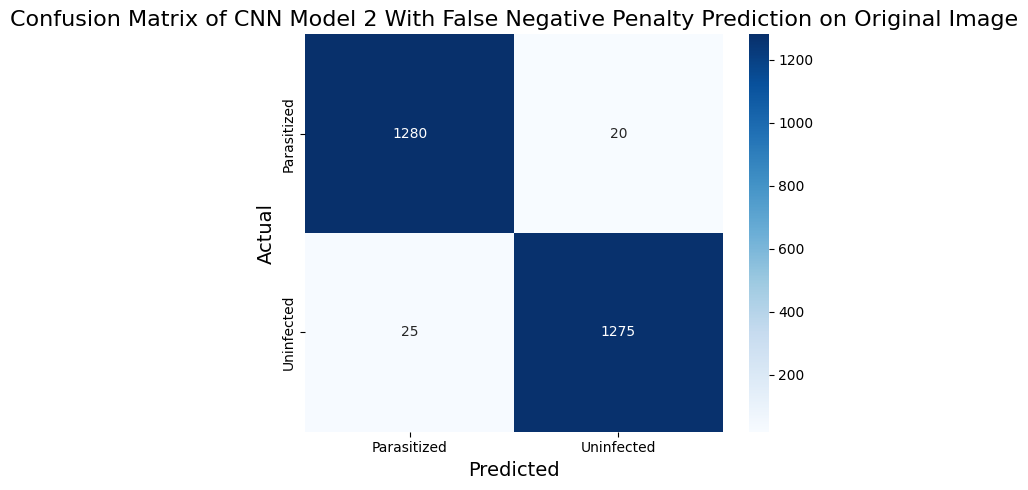

In [ ]:
plot_confusion_matrix(
    confusion_matrix(y_test_np, y_pred_2_fn_classes, labels=(1, 0)),
    class_names=['Parasitized', 'Uninfected'],
    title='Confusion Matrix of CNN Model 2 With False Negative Penalty Prediction on Original Image')

**Observations:**

Even though I added another CNN layer, model 2 performs only slightly better on the test set. On image that is classified correctly, the final cnn layers clearly identify the putple shaded in the original parasitized images, but it still has difficulty when those are on the boundary.

In model 2.5, our attempt to penalize more for false negative does not improve the recall rate in the test sample.

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###<b> Use image data generator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.05,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
    fill_mode='constant'
)

In [ ]:
it = datagen.flow(X_train_np, y_train_np)

In [ ]:
aug_X_train, aug_y_train = next(it)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

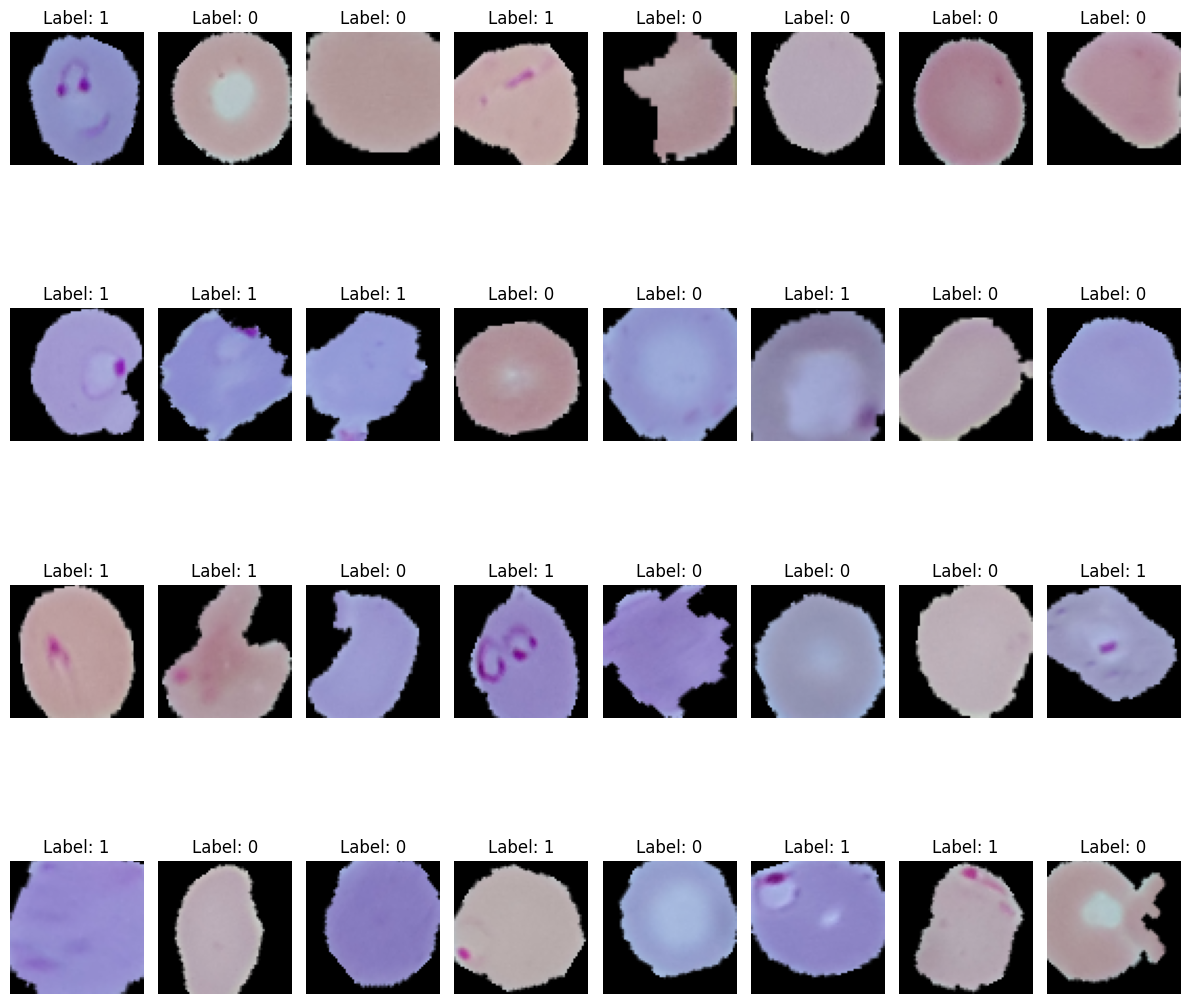

In [ ]:
fig = plt.figure(figsize=(12, 12))
for i in range(32):
  ax = fig.add_subplot(4, 8, i+1)
  ax.imshow(aug_X_train[i], cmap='gray')
  ax.title.set_text(f"Label: {aug_y_train[i]}")
  plt.axis('off')
plt.tight_layout()

In [ ]:
augmented_images = []
augmented_labels = []

augmented_data_size = 40000
while len(augmented_images) < augmented_data_size:
    batch_images, batch_labels = it.next()
    augmented_images.extend(batch_images)
    augmented_labels.extend(batch_labels)

# Convert lists to NumPy arrays
augmented_images = np.array(augmented_images)[:augmented_data_size]
augmented_labels = np.array(augmented_labels)[:augmented_data_size]


In [ ]:
augmented_labels_one_hot = to_categorical(augmented_labels)

In [ ]:
augmented_X_train_hsv = []
for image in augmented_images:
  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
  augmented_X_train_hsv.append(hsv_image)

In [ ]:
hsv_range = np.array([360, 1, 1])
augmented_X_train_hsv_normalized = np.array(augmented_X_train_hsv)
augmented_X_train_hsv_normalized = augmented_X_train_hsv_normalized / hsv_range

In [ ]:
augmented_X_train_blur = []
for image in augmented_X_train_hsv_normalized:
  blur_image = cv2.GaussianBlur(image, (3, 3), 0, 0)
  augmented_X_train_blur.append(blur_image)

In [ ]:
augmented_X_train_blur_normalized = np.stack(augmented_X_train_blur)

**Observations and insights:**

We see that the augmented images look different from the original images in some obvious ways, such as the boundary of the cell becoming connected to the edge of the images. I generated 20K images that may include the original images, apply the same hsv conversion and blur transformation.

###<b>Building the Model

In [ ]:
def build_model_3():
  set_seed()

  model = Sequential()
  model.add(Conv2D(32, (2, 2), padding = "same", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2D(32, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2D(64, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(128, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2D(128, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(256, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Conv2D(256, (2, 2), padding = "same"))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dropout(0.5))
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(2, activation='softmax'))

  return model

In [ ]:
model_3 = build_model_3()
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4128      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 32)        0

In [ ]:
model_3.compile(
  optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.005),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

<b>Using Callbacks

In [ ]:
# use a checkpoint callback to save the best model
model_3_filepath = os.path.join(CAPSTONE_PATH, 'model_3.h5')
checkpoint_3 = checkpoint_callback(model_3_filepath)

<b> Fit and Train the model

In [ ]:
history_3 = model_3.fit(
  augmented_X_train_blur_normalized,
  augmented_labels_one_hot,
  batch_size=256,
  epochs=10,
  validation_split=0.1,
  shuffle=True,
  callbacks=[checkpoint_3],
)

Epoch 1/10
141/141 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.8609

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


141/141 [==============================] - 114s 787ms/step - loss: 0.3454 - accuracy: 0.8609 - val_loss: 1.7636 - val_accuracy: 0.4970
Epoch 2/10
141/141 [==============================] - 108s 763ms/step - loss: 0.1322 - accuracy: 0.9557 - val_loss: 1.6645 - val_accuracy: 0.5257
Epoch 3/10
141/141 [==============================] - 109s 773ms/step - loss: 0.1089 - accuracy: 0.9647 - val_loss: 0.3122 - val_accuracy: 0.9075
Epoch 4/10
141/141 [==============================] - 109s 772ms/step - loss: 0.0986 - accuracy: 0.9687 - val_loss: 0.1953 - val_accuracy: 0.9367
Epoch 5/10
141/141 [==============================] - 109s 772ms/step - loss: 0.0913 - accuracy: 0.9702 - val_loss: 0.0843 - val_accuracy: 0.9725
Epoch 6/10
141/141 [==============================] - 109s 775ms/step - loss: 0.0873 - accuracy: 0.9716 - val_loss: 0.0857 - val_accuracy: 0.9707
Epoch 7/10
141/141 [==============================] - 109s 773ms/step - loss: 0.0843 - accuracy: 0.9732 - val_loss: 0.0982 - val_accura

###<B>Evaluating the model

<b>Plot the train and validation accuracy

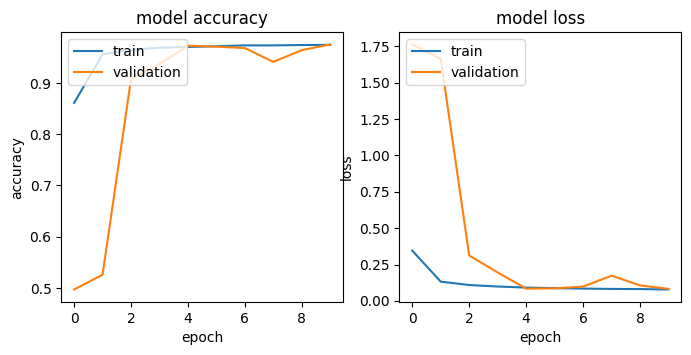

In [ ]:
plot_training_stats(history_3)

<B>Plotting the classification report and confusion matrix

First look at the classification report on the training sample

In [ ]:
# Make predictions on the test set using the second model.
y_pred_3 = model_3.predict(X_train_blur_normalized)
y_pred_3_classes = np.argmax(y_pred_3, axis=1)

# Print the obtained results using the classification report and the confusion matrix.
print(classification_report(y_train_np, y_pred_3_classes, labels=(1, 0)))

781/781 [==============================] - 19s 24ms/step
              precision    recall  f1-score   support

           1       0.97      0.99      0.98     12598
           0       0.99      0.97      0.98     12383

    accuracy                           0.98     24981
   macro avg       0.98      0.98      0.98     24981
weighted avg       0.98      0.98      0.98     24981



Then at the test sample

In [ ]:
# Make predictions on the test set using the second model.
y_pred_3 = model_3.predict(X_test_blur_normalized)
y_pred_3_classes = np.argmax(y_pred_3, axis=1)

# Print the obtained results using the classification report and the confusion matrix.
print(classification_report(y_test_np, y_pred_3_classes, labels=(1, 0)))

82/82 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           1       0.97      0.99      0.98      1300
           0       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



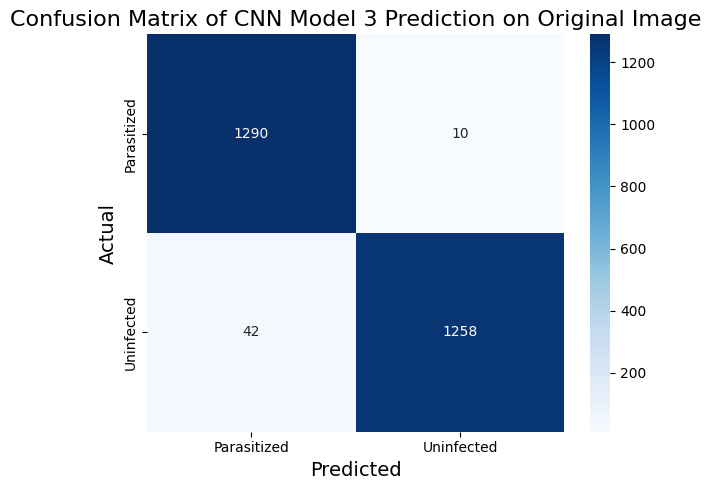

In [ ]:
plot_confusion_matrix(
    confusion_matrix(y_test_np, y_pred_3_classes, labels=(1, 0)),
    class_names=['Parasitized', 'Uninfected'],
    title='Confusion Matrix of CNN Model 3 Prediction on Original Image')

** Observation **


<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [ ]:
from keras.applications.vgg16 import VGG16

###<b>Compiling the model

In [ ]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg16_model.trainable = False
vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
def build_model_4():
  set_seed()
  vgg16_model.trainable = False

  transfer_layer = vgg16_model.get_layer('block3_pool')
  x = Conv2D(512, (2, 2), padding = "same")(transfer_layer.output)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Conv2D(512, (2, 2), padding = "same")(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Flatten()(x)
  x = Dense(512)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Dropout(0.5)(x)
  x = Dense(256)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.1)(x)
  x = Dropout(0.5)(x)
  pred = Dense(2, activation='softmax')(x)
  model = Model(vgg16_model.input, pred)
  return model

In [ ]:
model_4 = build_model_4()
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
model_4.compile(
  optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.002),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

<b> using callbacks

In [ ]:
model_4_filepath = os.path.join(CAPSTONE_PATH, 'model_4.h5')
checkpoint_4 = checkpoint_callback(model_4_filepath)

<b>Fit and Train the model

In [ ]:
history_4 = model_4.fit(
    X_train_blur_normalized, y_train_one_hot,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    shuffle=True,
    callbacks=[checkpoint_4]
)

Epoch 1/10
156/157 [============================>.] - ETA: 0s - loss: 0.4007 - accuracy: 0.8246

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 46s 286ms/step - loss: 0.4004 - accuracy: 0.8247 - val_loss: 5.4082 - val_accuracy: 0.0074
Epoch 2/10
157/157 [==============================] - 44s 280ms/step - loss: 0.2059 - accuracy: 0.9161 - val_loss: 0.0986 - val_accuracy: 0.9780
Epoch 3/10
157/157 [==============================] - 45s 286ms/step - loss: 0.1648 - accuracy: 0.9378 - val_loss: 0.2448 - val_accuracy: 0.9234
Epoch 4/10
157/157 [==============================] - 44s 283ms/step - loss: 0.1362 - accuracy: 0.9495 - val_loss: 0.0100 - val_accuracy: 0.9994
Epoch 5/10
157/157 [==============================] - 44s 281ms/step - loss: 0.1265 - accuracy: 0.9527 - val_loss: 0.1927 - val_accuracy: 0.9392
Epoch 6/10
157/157 [==============================] - 45s 284ms/step - loss: 0.1125 - accuracy: 0.9583 - val_loss: 0.1077 - val_accuracy: 0.9764
Epoch 7/10
157/157 [==============================] - 44s 278ms/step - loss: 0.1015 - accuracy: 0.9637 - val_loss: 0.0054 - val_accuracy: 0.9

<b>Plot the train and validation accuracy

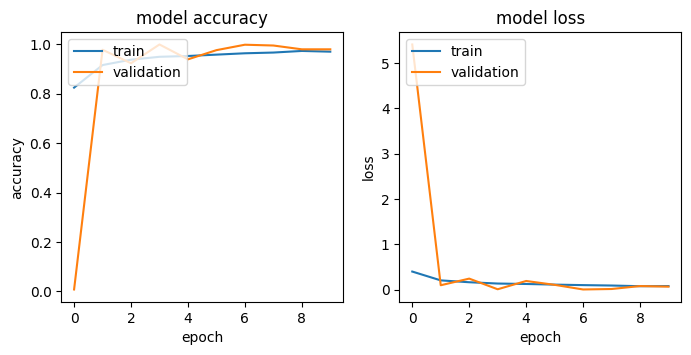

In [ ]:
plot_training_stats(history_4)

**Observations and insights:**

*   What can be observed from the validation and train curves?
Both loss curves lie below the previous model, which suggests


###<b> Evaluating the model

In [ ]:
y_pred_4 = model_4.predict(X_test_blur_normalized)
y_pred_4_classes = np.argmax(y_pred_4, axis=1)

print(classification_report(y_test_np, y_pred_4_classes))

82/82 [==============================] - 4s 49ms/step
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1300
           1       0.98      0.94      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



<b>Plotting the classification report and confusion matrix

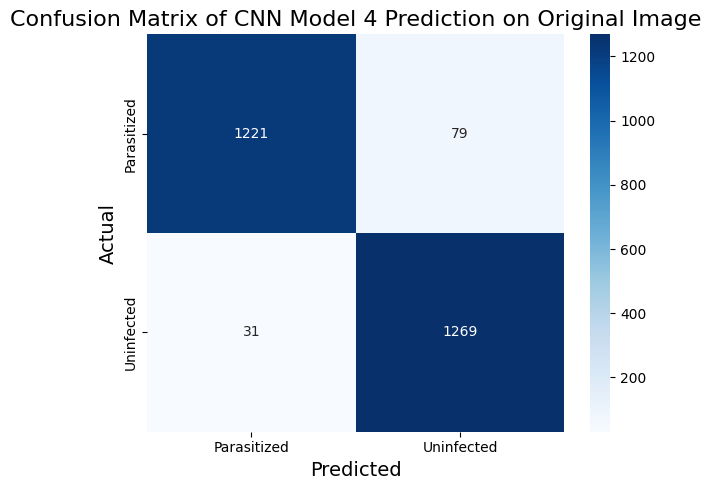

In [ ]:
plot_confusion_matrix(
    confusion_matrix(y_test_np, y_pred_4_classes, labels=(1, 0)),
    class_names=['Parasitized', 'Uninfected'],
    title='Confusion Matrix of CNN Model 4 Prediction on Original Image')

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


In [ ]:
final_model = model_3

**Observations and Conclusions drawn from the final model:**

Model 2 is chosen to be the final model for this milestone submission.

Below is a summary of different models used in this notebook

Model Name | Architecture | Regularization | Data
-----------|--------------|----------------|---------
Base Model | 3 CNN, 1 ANN | Dropout | Original Data
Model 1    | 4 CNN, 2 ANN | Dropout | Original Data
Model 2    | 8 CNN, 2 ANN | Dropout, Batch Normalization | Original Data
Model 3    | 8 CNN, 2 ANN | Dropout, Batch Normalization | Augmented Data
Model 4    | VGG16 Node 3, 2 CNN, 2 ANN | Dropout, Batch Normalization | Augmented Data

Model 2 is a deep CNN model training on the original data. It is deeper than the base model and Model 1 and employs batch normalization at every cnn layer. Model 3 is the same model as model 2 but trains on augemented data that includes some of the orignial data. It should perform much better out of sample, but perhaps due to the quality of the augmented data, its performance is only on par with that of model 2. Model 4, which is fine-tuned from VGG16 with its own cnn layers and fully connected layers and trained on augmented data, does not perform well at all, even underperform the base model.


**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

**Answer:**

- The model still produce a large enough false negative. at 98% recall, it has room to improve as an automated medical diagnosis system for lethal and cantagious disease. There are some parasitized RBCs imanges that are obvious to the human eyes, but cannot be predicted by the CNN because the most prominant feature--the purple bump or spots on the surface of the RBCs--are near the boundary (or on the side of) the RBCs images.

- The false negatives are generally images where the purple spots are near the RBC boundaries, and Conv2D Layers most likely treat those spots as part of an the cell boundary rather than the purple spots that are prominant features of the parasitized RBCs. I think addressing this issue can improve the model performance a great deal in terms of recall metrics.

#### **Insights**

####**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

####**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

####**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?




#Observations:
A few insights to be drawn from building and training this model
- deeper networks with proper regularization and batch normalization can outperform shallower networks on testing set.
- input normalization is very important. As HSV channels have very different value ranges, normalizing them properly greatly improves model performance.
- features that are at the boundary of the RBCs are really difficult to detect, even for the deep networks. While I have tried a few different padding methods in the input Conv2D layer, a deeper network has a bigger impact on model perforamce.
- fine-tuned VGG16 does not work nearly as well as our custom trained model, due perhaps to its inability to pick up important features early on.



## **Appendix**

### **Feature Maps**
Below we review the feature map produced by my final model on one misclassified image. This is the case where the purple stain is at the corner of the RBC image, and the feature map cannot capture such corner cases.

[0.6294022  0.37059775] 1
[404]


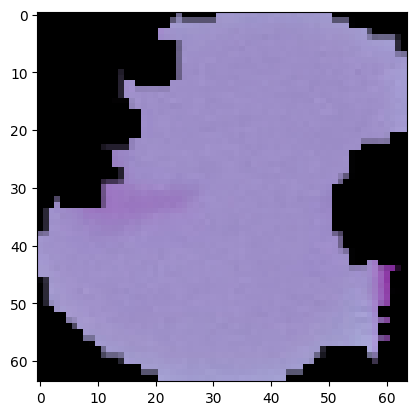

1/1 [==============================] - 0s 133ms/step


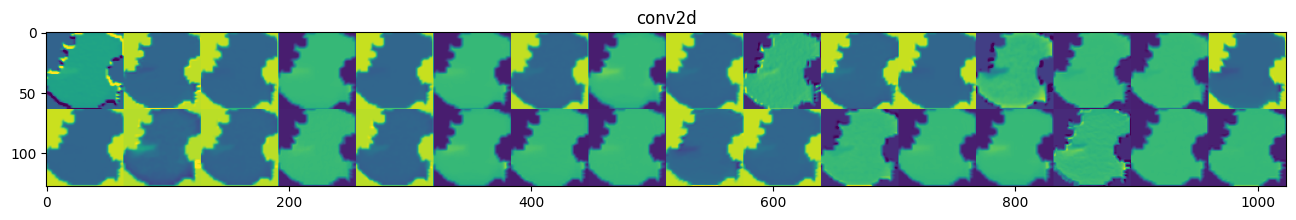

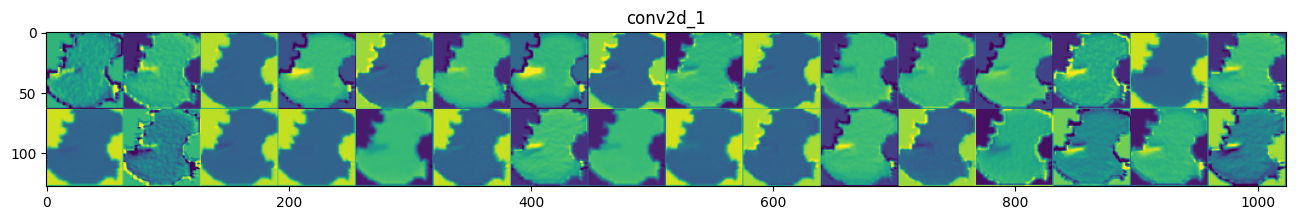

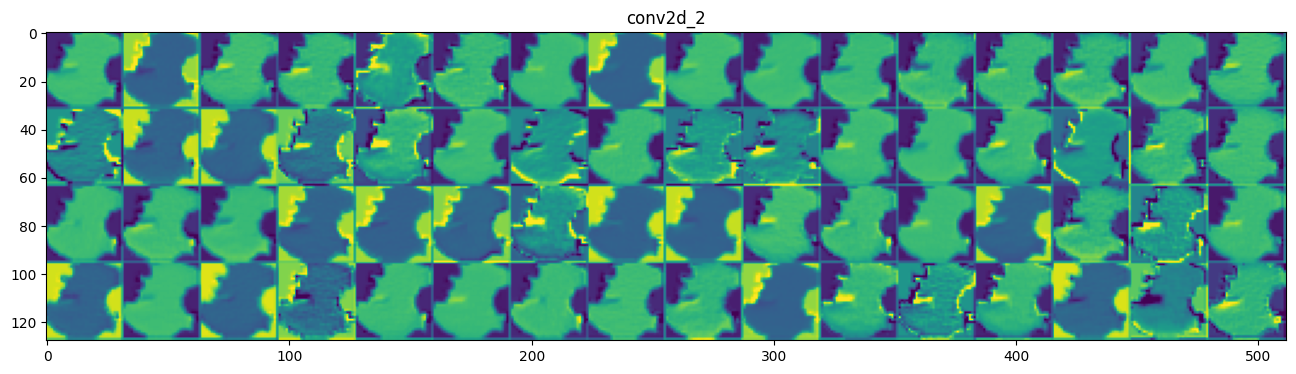

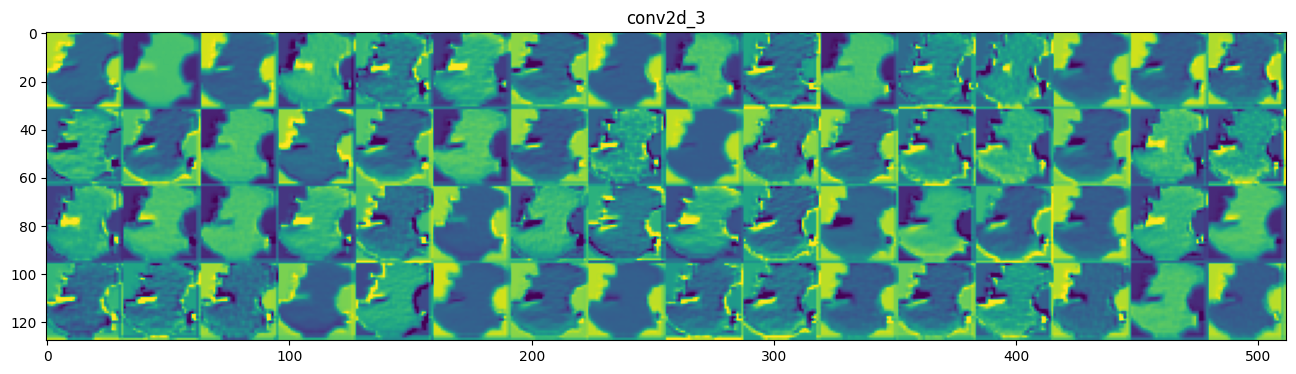

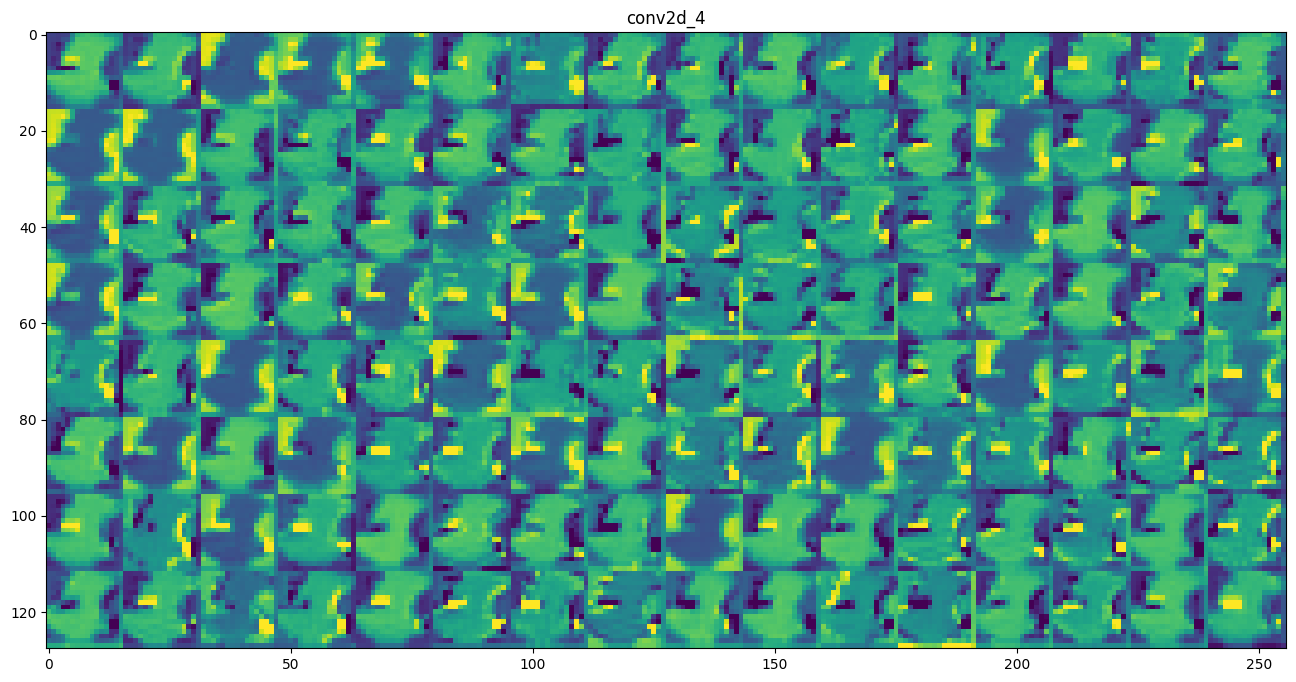

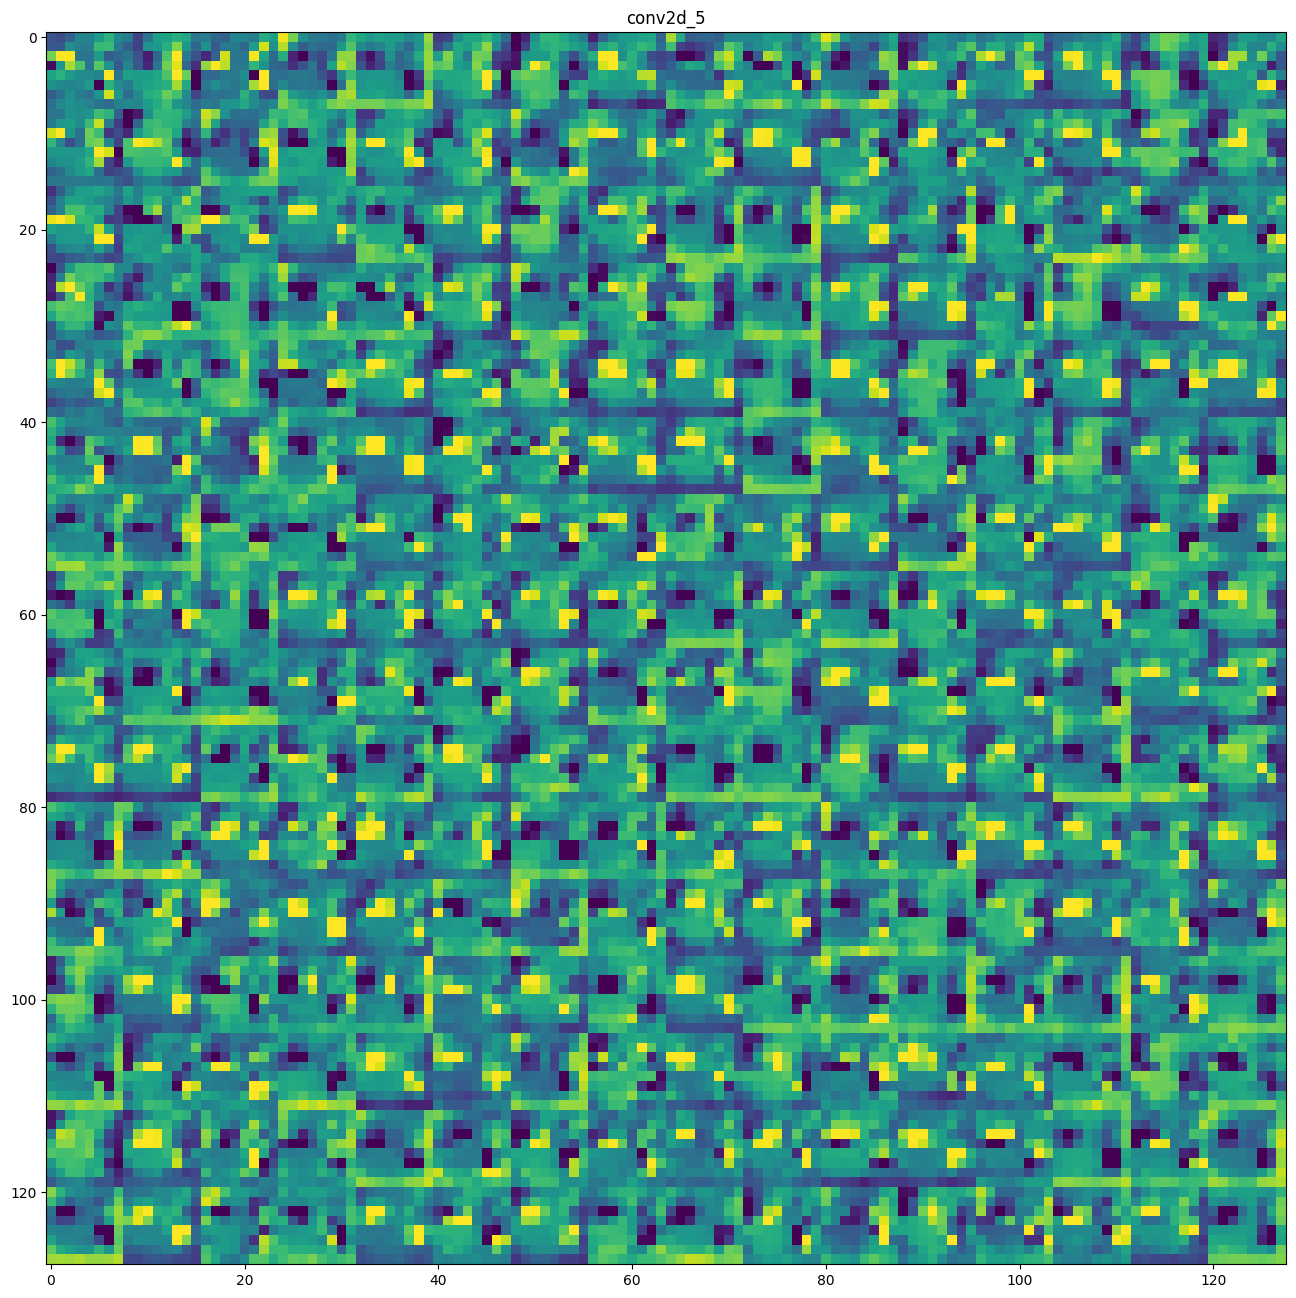

In [ ]:
mis_classified = np.where(y_pred_3_classes != y_test_np)[0][0]
print(y_pred_3[mis_classified], y_test_np[mis_classified])
img_idx = np.array([mis_classified])
print(img_idx)
visualize_activations(model_3, X_test_np[img_idx], X_test_blur_normalized[img_idx])

### Export Notebooks to HTML

In [ ]:
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")


Saving Reference_Notebook_Malaria_Detection_Full_Code.ipynb to Reference_Notebook_Malaria_Detection_Full_Code.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>